# Verifizierung des Modells

Dieses Notebook dient der Verifizierung des Energiesystemmodells **burn4h2**.

## 1. Setup & Bibliotheken

Zuerst importieren wir die benötigten Bibliotheken und Module.

In [287]:
# Bibliotheken importieren
import os
import sys
import glob
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re
import datetime

notebook_dir = os.getcwd()
project_root = os.path.abspath(os.path.join(notebook_dir, '..', '..'))
print(f"Project root: {project_root}")
if project_root not in sys.path:
    sys.path.append(project_root)

# Die neue Klasse importieren
from postprocessing.utils.scenario_data import ScenarioData, ScenarioCollection
# from postprocessing.utils.scenario_plotter import ScenarioPlotter, ComparisonPlotter

# Datenpfade definieren
ASSETS_PATH = os.path.join(project_root, 'data', 'input', 'assets')
DATA_PATH = os.path.join(project_root, 'data', 'output')
OUTPUT_PATH = os.path.join(project_root, 'postprocessing', 'output')
os.makedirs(OUTPUT_PATH, exist_ok=True)

# Ausgabe der Pfade
print(f"Verwende Assets-Pfad: {ASSETS_PATH}")
print(f"Verwende Datenpfad: {DATA_PATH}")
print(f"Verwende Ausgabe-Pfad: {OUTPUT_PATH}")

# Zunächst die vorhandene Verzeichnisstruktur prüfen
print("\nVerfügbare Verzeichnisse im Datenpfad:")
if os.path.exists(DATA_PATH):
    dirs = [d for d in os.listdir(DATA_PATH) if os.path.isdir(os.path.join(DATA_PATH, d))]
    for d in dirs:
        print(f"- {d}")
else:
    print(f"WARNUNG: Der Pfad {DATA_PATH} existiert nicht!")


Project root: c:\Users\wlhlm\VSCodeProjects\burn4h2
Verwende Assets-Pfad: c:\Users\wlhlm\VSCodeProjects\burn4h2\data\input\assets
Verwende Datenpfad: c:\Users\wlhlm\VSCodeProjects\burn4h2\data\output
Verwende Ausgabe-Pfad: c:\Users\wlhlm\VSCodeProjects\burn4h2\postprocessing\output

Verfügbare Verzeichnisse im Datenpfad:
- archive
- dummy
- postprocessing
- uc1
- uc2


In [288]:
# Konfigurationsparameter für die Analyse
YEAR = "2030"               # Kann geändert werden zu 2040 oder 2050
USE_CASE = "uc1"            # Kann geändert werden zu uc2
H2_ADMIXTURES = [0, 30, 50, 100]  # Zu analysierende Wasserstoffbeimischungen
ANALYZE_CHP_UNITS = [1, 2]        # CHP-Einheiten, die analysiert werden sollen

In [289]:

def load_chp_technical_parameters(assets_path=ASSETS_PATH):
    """Lädt die technischen Parameter der CHP-Anlagen für verschiedene H2-Beimischungen."""
    chp_params = {}
    
    # Lade Parameter für 0% H2 (Standard-CHP)
    chp_file = os.path.join(assets_path, "chp.csv")
    if os.path.exists(chp_file):
        chp_params[0] = pd.read_csv(chp_file)
        print(f"CHP-Parameter für 0% H2 geladen")
    
    # Lade Parameter für verschiedene H2-Beimischungen
    for admixture in [30, 50, 100]:
        chp_file = os.path.join(assets_path, f"chp_h2_{admixture}.csv")
        if os.path.exists(chp_file):
            chp_params[admixture] = pd.read_csv(chp_file)
            print(f"CHP-Parameter für {admixture}% H2 geladen")
    
    return chp_params


def identify_scenarios(year=YEAR, use_case=USE_CASE, admixtures=H2_ADMIXTURES):
    """Identifiziert die zu analysierenden Szenarien basierend auf Jahr, Use Case und Beimischung."""
    selected_scenarios = []
    
    for admixture in admixtures:
        # Szenarionamen erstellen
        scenario_name = f"{use_case}_{year}_{admixture}h2"
        scenario_path = os.path.join(use_case, scenario_name)
        
        # Prüfen, ob das Szenario existiert und Output-Dateien hat
        if os.path.exists(os.path.join(DATA_PATH, use_case, scenario_name)):
            output_files = glob.glob(os.path.join(DATA_PATH, use_case, scenario_name, '*_output.csv'))
            if output_files:
                selected_scenarios.append(scenario_path)
                print(f"Szenario gefunden: {scenario_name}")
            else:
                print(f"Szenario {scenario_name} existiert, hat aber keine Output-Dateien")
        else:
            print(f"Szenario {scenario_name} existiert nicht")
    
    return selected_scenarios

In [290]:

# Technische Parameter laden
chp_technical_params = load_chp_technical_parameters()

# Kurze Zusammenfassung der Parameter anzeigen
for admixture, params in chp_technical_params.items():
    print(f"\nParameter für {admixture}% H2:")
    print(params)


CHP-Parameter für 0% H2 geladen
CHP-Parameter für 30% H2 geladen
CHP-Parameter für 50% H2 geladen
CHP-Parameter für 100% H2 geladen

Parameter für 0% H2:
  index      gas   power  heat     co2  waste_heat
0   min   64.794  13.410  41.3  13.107         1.6
1   max  156.328  62.424  82.0  31.524         1.9

Parameter für 30% H2:
  index      gas   power    heat     co2  waste_heat
0   min   63.568  11.393  32.028  13.107         1.6
1   max  153.370  53.038  63.590  31.524         1.9

Parameter für 50% H2:
  index      gas   power    heat     co2  waste_heat
0   min   63.601  10.322  29.206  13.107         1.6
1   max  153.450  48.050  57.988  31.524         1.9

Parameter für 100% H2:
  index      gas   power    heat     co2  waste_heat
0   min   64.646  16.147  40.003  13.107         1.6
1   max  155.800  64.589  75.491  31.524         1.9


In [291]:
# Identifiziere und lade die Szenarien
selected_scenarios = identify_scenarios()
print(f"\nGefundene Szenarien: {len(selected_scenarios)}")

# Lade die ausgewählten Szenarien
if selected_scenarios:
    # Szenariosammlung initialisieren (falls noch nicht geschehen)
    if 'collection' not in locals():
        collection = ScenarioCollection(DATA_PATH)
    
    # Szenarien laden
    for scenario_path in selected_scenarios:
        scenario_name = os.path.basename(scenario_path)
        print(f"Lade {scenario_name}...")
        scenario = ScenarioData(scenario_name, os.path.join(DATA_PATH, os.path.dirname(scenario_path)))
        scenario.load_all_data()
        collection.scenarios[scenario_name] = scenario
    
    # Daten verarbeiten
    collection.preprocess_all().add_datetime_all()
    
    # Szenarioübersicht anzeigen
    print("\n--- Verfügbare Szenarien für die Analyse ---")
    for name, scenario in collection.scenarios.items():
        if name.startswith(f"{USE_CASE}_{YEAR}_"):
            summary = scenario.summary()
            h2_level = name.split('_')[-1].replace('h2', '')
            print(f"Szenario: {name}, H2-Beimischung: {h2_level}%")
else:
    print(f"Keine Szenarien für {USE_CASE}_{YEAR} mit H2-Beimischungen {H2_ADMIXTURES} gefunden.")

Szenario gefunden: uc1_2030_0h2
Szenario gefunden: uc1_2030_30h2
Szenario gefunden: uc1_2030_50h2
Szenario gefunden: uc1_2030_100h2

Gefundene Szenarien: 4
Lade uc1_2030_0h2...
Kostendaten aus uc1_2030_0h2_20250430_141740_costs.json geladen.
Metadaten aus uc1_2030_0h2_20250430_141740_metadata.json geladen.
Ausgabedaten aus uc1_2030_0h2_20250430_141740_output.csv geladen.
Lade uc1_2030_30h2...
Kostendaten aus uc1_2030_30h2_20250430_220853_costs.json geladen.
Metadaten aus uc1_2030_30h2_20250430_220853_metadata.json geladen.
Ausgabedaten aus uc1_2030_30h2_20250430_220853_output.csv geladen.
Lade uc1_2030_50h2...
Kostendaten aus uc1_2030_50h2_20250430_193756_costs.json geladen.
Metadaten aus uc1_2030_50h2_20250430_193756_metadata.json geladen.
Ausgabedaten aus uc1_2030_50h2_20250430_193756_output.csv geladen.
Lade uc1_2030_100h2...
Kostendaten aus uc1_2030_100h2_20250430_171323_costs.json geladen.
Metadaten aus uc1_2030_100h2_20250430_171323_metadata.json geladen.
Ausgabedaten aus uc1_203

In [292]:
def analyze_chp_operation(scenario, chp_unit, h2_admixture, tech_params):
    """
    Analysiert den Betrieb einer CHP-Einheit in einem Szenario.
    
    Args:
        scenario: Das ScenarioData-Objekt
        chp_unit: Die CHP-Einheit (1 oder 2)
        h2_admixture: Die H2-Beimischung (0, 30, 50, 100)
        tech_params: Die technischen Parameter der CHP-Anlagen
    
    Returns:
        Dictionary mit Betriebsanalysen
    """
    # Relevante technische Parameter extrahieren
    if h2_admixture not in tech_params:
        print(f"Warnung: Keine technischen Parameter für {h2_admixture}% H2 gefunden")
        return None
    
    params = tech_params[h2_admixture]
    min_gas = params.loc[params['index'] == 'min', 'gas'].values[0]
    max_gas = params.loc[params['index'] == 'max', 'gas'].values[0]
    min_power = params.loc[params['index'] == 'min', 'power'].values[0]
    max_power = params.loc[params['index'] == 'max', 'power'].values[0]
    min_heat = params.loc[params['index'] == 'min', 'heat'].values[0]
    max_heat = params.loc[params['index'] == 'max', 'heat'].values[0]
    
    # Daten extrahieren
    df = scenario.processed_output
    
    # Relevante Spalten definieren
    bin_col = f"chp_{chp_unit}.bin"
    gas_col = f"chp_{chp_unit}.gas"
    power_col = f"chp_{chp_unit}.power"
    heat_col = f"chp_{chp_unit}.heat"
    co2_col = f"chp_{chp_unit}.co2"
    waste_heat_col = f"chp_{chp_unit}.waste_heat"
    hydrogen_col = f"chp_{chp_unit}.hydrogen"
    natural_gas_col = f"chp_{chp_unit}.natural_gas"
    
    # Relevante Spalten prüfen und Fehlende notieren
    missing_cols = []
    for col in [bin_col, gas_col, power_col, heat_col]:
        if col not in df.columns:
            missing_cols.append(col)
    
    if missing_cols:
        print(f"Warnung: Folgende Spalten fehlen für CHP {chp_unit}: {', '.join(missing_cols)}")
        return None
    
    # Betriebsdaten filtern (nur wenn die Anlage läuft)
    operating_data = df[df[bin_col] > 0.5]
    
    
    if len(operating_data) == 0:
        print(f"Warnung: Keine Betriebsdaten für CHP {chp_unit} gefunden")
        return None
    
    # Lastindex berechnen (normiert zwischen Min- und Max-Last)
    load_index = (operating_data[gas_col] - min_gas) / (max_gas - min_gas)
    load_index = load_index.clip(0, 1)  # Auf den Bereich [0, 1] beschränken



    # Teillast (index < 0.5) und Volllast (index >= 0.5) definieren
    part_load = operating_data[load_index < 0.5]
    full_load = operating_data[load_index >= 0.5]
    
    # Betriebsstunden berechnen
    total_hours = len(df)
    operating_hours = len(operating_data)
    part_load_hours = len(part_load)
    full_load_hours = len(full_load)
    
    # Durchschnittliche Betriebswerte berechnen
    avg_gas = operating_data[gas_col].mean() if operating_hours > 0 else 0
    avg_power = operating_data[power_col].mean() if operating_hours > 0 else 0
    avg_heat = operating_data[heat_col].mean() if operating_hours > 0 else 0
    
    # Wirkungsgrade berechnen
    if not part_load.empty:
        el_eff_part = part_load[power_col].mean() / part_load[gas_col].mean() * 100
        th_eff_part = part_load[heat_col].mean() / part_load[gas_col].mean() * 100
        total_eff_part = el_eff_part + th_eff_part
    else:
        el_eff_part = th_eff_part = total_eff_part = 0
    
    if not full_load.empty:
        el_eff_full = full_load[power_col].mean() / full_load[gas_col].mean() * 100
        th_eff_full = full_load[heat_col].mean() / full_load[gas_col].mean() * 100
        total_eff_full = el_eff_full + th_eff_full
    else:
        el_eff_full = th_eff_full = total_eff_full = 0
    
    # CO2-Emissionen (falls verfügbar)
    if co2_col in operating_data.columns:
        avg_co2 = operating_data[co2_col].mean() if operating_hours > 0 else 0
    else:
        avg_co2 = None
    
    # Ergebnisse sammeln
    results = {
        'scenario': scenario.scenario_name,
        'chp_unit': chp_unit,
        'h2_admixture': h2_admixture,
        'total_hours': total_hours,
        'operating_hours': operating_hours,
        'part_load_hours': part_load_hours,
        'full_load_hours': full_load_hours,
        'operating_percent': operating_hours / total_hours * 100 if total_hours > 0 else 0,
        'part_load_percent': part_load_hours / operating_hours * 100 if operating_hours > 0 else 0,
        'full_load_percent': full_load_hours / operating_hours * 100 if operating_hours > 0 else 0,
        'avg_gas': avg_gas,
        'avg_power': avg_power,
        'avg_heat': avg_heat,
        'avg_co2': avg_co2,
        'el_eff_part': el_eff_part,
        'th_eff_part': th_eff_part,
        'total_eff_part': total_eff_part,
        'el_eff_full': el_eff_full,
        'th_eff_full': th_eff_full,
        'total_eff_full': total_eff_full,
    }
    
    return results



In [293]:
def run_chp_analysis(collection, chp_units=ANALYZE_CHP_UNITS, h2_admixtures=H2_ADMIXTURES):
    """Führt die CHP-Analyse für alle Szenarien durch."""
    results = []
    
    # Für jedes relevante Szenario die Analyse durchführen
    for scenario_name, scenario in collection.scenarios.items():
        if not scenario_name.startswith(f"{USE_CASE}_{YEAR}_"):
            continue
            
        # H2-Beimischung aus dem Namen extrahieren
        h2_match = re.search(r'_(\d+)h2', scenario_name)
        if not h2_match:
            print(f"Warnung: Konnte H2-Beimischung nicht aus dem Namen '{scenario_name}' extrahieren")
            continue
            
        h2_admixture = int(h2_match.group(1))
        if h2_admixture not in h2_admixtures:
            continue
            
        print(f"\nAnalysiere {scenario_name} (H2-Beimischung: {h2_admixture}%)")
        
        # Jede CHP-Einheit analysieren
        for chp_unit in chp_units:
            print(f"  Analysiere CHP {chp_unit}...")
            result = analyze_chp_operation(scenario, chp_unit, h2_admixture, chp_technical_params)
            if result:
                results.append(result)
                
    return results

# CHP-Analyse durchführen
if 'collection' in locals() and collection.scenarios:
    chp_analysis_results = run_chp_analysis(collection)
    
    # Ergebnisse in DataFrame konvertieren für bessere Übersicht
    if chp_analysis_results:
        results_df = pd.DataFrame(chp_analysis_results)
        print("\nZusammenfassung der CHP-Analyse:")
        print(results_df[['scenario', 'chp_unit', 'h2_admixture', 'operating_percent', 'part_load_percent', 
                          'el_eff_part', 'el_eff_full', 'total_eff_part', 'total_eff_full']])
        
        # Ergebnisse speichern
        results_df.to_csv(os.path.join(OUTPUT_PATH, f'chp_analysis_{USE_CASE}_{YEAR}.csv'), index=False)
        print(f"Detaillierte Ergebnisse gespeichert in: {os.path.join(OUTPUT_PATH, f'chp_analysis_{USE_CASE}_{YEAR}.csv')}")
    else:
        print("Keine Analyseergebnisse gefunden.")
else:
    print("Keine Szenarien für die Analyse verfügbar.")


Analysiere uc1_2030_0h2 (H2-Beimischung: 0%)
  Analysiere CHP 1...
  Analysiere CHP 2...

Analysiere uc1_2030_30h2 (H2-Beimischung: 30%)
  Analysiere CHP 1...
  Analysiere CHP 2...

Analysiere uc1_2030_50h2 (H2-Beimischung: 50%)
  Analysiere CHP 1...
  Analysiere CHP 2...

Analysiere uc1_2030_100h2 (H2-Beimischung: 100%)
  Analysiere CHP 1...
  Analysiere CHP 2...

Zusammenfassung der CHP-Analyse:
         scenario  chp_unit  h2_admixture  operating_percent  \
0    uc1_2030_0h2         1             0          37.694064   
1    uc1_2030_0h2         2             0          33.789954   
2   uc1_2030_30h2         1            30          47.157534   
3   uc1_2030_30h2         2            30          46.780822   
4   uc1_2030_50h2         1            50          51.632420   
5   uc1_2030_50h2         2            50          50.650685   
6  uc1_2030_100h2         1           100          65.570776   
7  uc1_2030_100h2         2           100          65.570776   

   part_load_percent 

In [294]:
collection

In [ ]:
def calculate_critical_spark_spread_timeseries(scenario, tech_params, chp_unit, h2_admixture, year=YEAR):
    """
    Berechnet den Critical Spark Spread für jeden Zeitpunkt der Zeitreihe.
    
    Die Brennstoffkosten werden getrennt für Erdgas und Wasserstoff berechnet,
    basierend auf den tatsächlichen Energieanteilen und Preisen.
    """
    # CO2-Kosten je nach Jahr auswählen (€/Tonne)
    co2_price_dict = {
        "2030": 125.0,
        "2040": 162.04,
        "2050": 370.38
    }
    co2_price = co2_price_dict.get(year, 125.0)  # Default: 2030
    print(f"Verwende CO2-Preis für {year}: {co2_price} €/t")
    
    # Technische Parameter für die CHP-Einheit laden
    if h2_admixture not in tech_params:
        print(f"Warnung: Keine technischen Parameter für {h2_admixture}% H2 gefunden")
        return pd.DataFrame()  # Leeres DataFrame zurückgeben
        
    params = tech_params[h2_admixture]
    min_gas = params.loc[params['index'] == 'min', 'gas'].values[0]
    max_gas = params.loc[params['index'] == 'max', 'gas'].values[0]
    min_power = params.loc[params['index'] == 'min', 'power'].values[0]
    max_power = params.loc[params['index'] == 'max', 'power'].values[0]
    min_co2 = params.loc[params['index'] == 'min', 'co2'].values[0]
    max_co2 = params.loc[params['index'] == 'max', 'co2'].values[0]
    
    # Zugriff auf das Dataframe mit den Simulationsergebnissen
    df = scenario.processed_output
    
    # Prüfen, ob die notwendigen Preisdaten vorhanden sind
    has_prices = 'power_price' in df.columns and 'gas_price' in df.columns and 'hydrogen_price' in df.columns
    
    if not has_prices:
        print("Warnung: Erforderliche Preisspalten fehlen:")
        if 'power_price' not in df.columns:
            print("- power_price nicht gefunden")
        if 'gas_price' not in df.columns:
            print("- gas_price nicht gefunden")
        if 'hydrogen_price' not in df.columns:
            print("- hydrogen_price nicht gefunden")
        print(f"Verfügbare Spalten: {df.columns.tolist()}")
        
        # Standard-Preise verwenden, wenn Daten fehlen
        power_price = 50.0  # €/MWh
        gas_price = 70.0    # €/MWh
        h2_price = 100.0    # €/MWh
        
        # Ergebnis-DataFrame mit konstanten Werten erstellen
        result_df = pd.DataFrame(index=df.index)
        result_df['electricity_price'] = power_price
    else:
        # Kopiere das Ursprungs-DataFrame, um die Indizes konsistent zu halten
        result_df = pd.DataFrame(index=df.index)
        
        # Strompreis aus dem Originaldataframe kopieren
        result_df['electricity_price'] = df['power_price']
    
    # Volumenverhältnisse (0-1 Skala)
    vol_h2 = h2_admixture / 100  # z.B. 0.3 für 30% H2
    vol_ng = 1 - vol_h2
    
    # Energiedichten [MJ/m³]
    HV_H2 = 120.0  # Hydrogen heating value [MJ/kg]
    HV_NG = 47.0   # Natural gas heating value [MJ/kg]
    RHO_H2 = 0.09  # Hydrogen density [kg/m³]
    RHO_NG = 0.68  # Natural gas density [kg/m³]
    
    energy_density_h2 = RHO_H2 * HV_H2  # ~10.8 MJ/m³
    energy_density_ng = RHO_NG * HV_NG  # ~32.0 MJ/m³
    
    # Energiefraktionen berechnen (aus chp.py-Methoden)
    energy_fraction_h2 = (vol_h2 * energy_density_h2) / (vol_h2 * energy_density_h2 + vol_ng * energy_density_ng)
    energy_fraction_ng = (vol_ng * energy_density_ng) / (vol_h2 * energy_density_h2 + vol_ng * energy_density_ng)
    
    print(f"Berechnete Energiefraktionen: H2: {energy_fraction_h2:.4f}, Erdgas: {energy_fraction_ng:.4f}")
    
    # Brennstoffkosten berechnen
    if has_prices:
        # Brennstoffkosten für Min-Last
        result_df['min_natural_gas_cost'] = min_gas * energy_fraction_ng * df['gas_price']
        result_df['min_hydrogen_cost'] = min_gas * energy_fraction_h2 * df['hydrogen_price']
        result_df['min_fuel_cost'] = result_df['min_natural_gas_cost'] + result_df['min_hydrogen_cost']
        
        # Brennstoffkosten für Max-Last
        result_df['max_natural_gas_cost'] = max_gas * energy_fraction_ng * df['gas_price']
        result_df['max_hydrogen_cost'] = max_gas * energy_fraction_h2 * df['hydrogen_price']
        result_df['max_fuel_cost'] = result_df['max_natural_gas_cost'] + result_df['max_hydrogen_cost']
 

    # CO2-Emissionen berechnen - Korrektur: Anteil ist proportional zu (1-h2_admixture/100)
    # h2_admixture ist in Prozent (0-100), daher Division durch 100
    min_co2_emissions = min_co2 * (1 - h2_admixture/100)
    max_co2_emissions = max_co2 * (1 - h2_admixture/100)
    
    # CO2-Kosten bei Min- und Maxlast
    min_co2_cost = min_co2_emissions * co2_price
    max_co2_cost = max_co2_emissions * co2_price
    
    # Gesamtkosten (Brennstoff + CO2)
    result_df['min_total_cost'] = result_df['min_fuel_cost'] + min_co2_cost
    result_df['max_total_cost'] = result_df['max_fuel_cost'] + max_co2_cost
    
    # result_df['min_total_cost'] = result_df['min_fuel_cost']
    # result_df['max_total_cost'] = result_df['max_fuel_cost']


    # Zusätzliche Kosten und Leistung
    result_df['additional_cost'] = result_df['max_total_cost'] - result_df['min_total_cost']
    additional_power = max_power - min_power
    
    # Critical Spark Spread berechnen (€/MWh)
    result_df['critical_spark_spread'] = result_df['additional_cost'] / additional_power
    
    # Wenn das DataFrame einen DatetimeIndex hat, diese als Spalte hinzufügen
    if isinstance(result_df.index, pd.DatetimeIndex):
        result_df['datetime'] = result_df.index
    
    # Debug-Ausgabe der ersten Zeilen
    print("\nErste Zeilen des Ergebnis-DataFrames:")
    print(result_df.head(3))
    
    # Prüfen auf NaN-Werte
    nan_count = result_df['critical_spark_spread'].isna().sum()
    if nan_count > 0:
        print(f"Warnung: {nan_count} NaN-Werte in critical_spark_spread gefunden")
    
    return result_df



In [296]:
def analyze_critical_spark_spread_timeseries(collection, chp_units=ANALYZE_CHP_UNITS, h2_admixtures=H2_ADMIXTURES):
    """Führt eine vereinfachte zeitreihenbasierte Critical Spark Spread Analyse für alle Szenarien durch."""
    
    for scenario_name, scenario in collection.scenarios.items():
        if not scenario_name.startswith(f"{USE_CASE}_{YEAR}_"):
            continue
            
        # H2-Beimischung aus dem Namen extrahieren
        h2_match = re.search(r'_(\d+)h2', scenario_name)
        if not h2_match:
            print(f"Warnung: Konnte H2-Beimischung nicht aus '{scenario_name}' extrahieren")
            continue
            
        h2_admixture = int(h2_match.group(1))
        if h2_admixture not in h2_admixtures:
            continue
            
        print(f"\nBerechne Critical Spark Spread Zeitreihe für {scenario_name}")
        
        # Für jede CHP-Einheit analysieren
        for chp_unit in chp_units:
            print(f"  Analysiere CHP {chp_unit}...")
            
            # Critical Spark Spread Zeitreihe berechnen
            css_timeseries = calculate_critical_spark_spread_timeseries(
                scenario, 
                chp_technical_params, 
                chp_unit, 
                h2_admixture, 
                year=YEAR
            )
            
            # Ergebnisse visualisieren
            if not css_timeseries.empty:
                # Zeitreihenplot erstellen
                plt.figure(figsize=(12, 6))
                
                # Bestimmen, welche Spalte für die X-Achse verwendet wird
                x_column = 'datetime' if 'datetime' in css_timeseries.columns else 'timestamp'
                
                # Critical Spark Spread
                plt.plot(css_timeseries[x_column], css_timeseries['critical_spark_spread'], 
                        label='Critical Spark Spread', color='blue', linewidth=1.5)
                
                # Strompreis zum Vergleich
                plt.plot(css_timeseries[x_column], css_timeseries['electricity_price'], 
                        label='Strompreis', color='green', alpha=0.7, linewidth=1)
                
                # Bereiche markieren, wo der CSS unter dem Strompreis liegt
                profitable = css_timeseries['critical_spark_spread'] < css_timeseries['electricity_price']
                if profitable.any():
                    plt.fill_between(
                        css_timeseries[x_column],
                        css_timeseries['critical_spark_spread'],
                        css_timeseries['electricity_price'],
                        where=profitable,
                        color='green', alpha=0.3,
                        label='Profitabler Vollastbetrieb'
                    )
                
                plt.title(f'Critical Spark Spread Zeitreihe - CHP {chp_unit}, {h2_admixture}% H2', fontsize=14)
                plt.xlabel('Datum' if x_column == 'datetime' else 'Zeitschritt', fontsize=12)
                plt.ylabel('Preis (€/MWh)', fontsize=12)
                plt.grid(True, linestyle='--', alpha=0.7)
                plt.legend()
                plt.tight_layout()
                
                # Speichere Plot
                output_dir = os.path.join(OUTPUT_PATH, f'css_timeseries_{USE_CASE}_{YEAR}')
                os.makedirs(output_dir, exist_ok=True)
                plt.savefig(os.path.join(output_dir, f'css_timeseries_chp{chp_unit}_{h2_admixture}h2.png'), dpi=300)
                plt.show()
                
                # Statistik der Critical Spark Spread Werte
                css_stats = css_timeseries['critical_spark_spread'].describe()
                print(f"\nStatistik für Critical Spark Spread - CHP {chp_unit}, {h2_admixture}% H2:")
                print(css_stats)
                
                # Anteil der profitablen Stunden
                profitable_hours = profitable.sum()
                total_hours = len(css_timeseries)
                profitable_pct = profitable_hours / total_hours * 100 if total_hours > 0 else 0
                print(f"Anteil profitabler Stunden: {profitable_hours} von {total_hours} ({profitable_pct:.1f}%)")
                
                # Monatliche Analyse nur durchführen, wenn datetime verfügbar ist
                if 'datetime' in css_timeseries.columns and hasattr(css_timeseries['datetime'].iloc[0], 'date'):
                    try:
                        # Monatliche Durchschnittswerte berechnen (einfacher als Boxplots)
                        css_timeseries['month'] = css_timeseries['datetime'].dt.month
                        monthly_avg = css_timeseries.groupby('month')['critical_spark_spread'].mean()
                        
                        # Einfachen Linienplot für monatliche Durchschnittswerte erstellen
                        plt.figure(figsize=(14, 6))
                        months = sorted(monthly_avg.index)
                        plt.plot(months, monthly_avg.values, 'o-', linewidth=2, markersize=8)
                        plt.title(f'Monatliche Durchschnittswerte Critical Spark Spread - CHP {chp_unit}, {h2_admixture}% H2', fontsize=14)
                        plt.xlabel('Monat', fontsize=12)
                        plt.ylabel('Critical Spark Spread (€/MWh)', fontsize=12)
                        plt.xticks(months)
                        plt.grid(True, linestyle='--', alpha=0.7)
                        plt.savefig(os.path.join(output_dir, f'css_monthly_chp{chp_unit}_{h2_admixture}h2.png'), dpi=300)
                        plt.show()
                    except Exception as e:
                        print(f"Warnung: Konnte monatliche Analyse nicht durchführen: {e}")

Daten für uc1_2030_0h2 vorverarbeitet.
Daten für uc1_2030_30h2 vorverarbeitet.
Daten für uc1_2030_50h2 vorverarbeitet.
Daten für uc1_2030_100h2 vorverarbeitet.
Daten für uc1_2040_0h2 vorverarbeitet.
Daten für uc1_2040_30h2 vorverarbeitet.
Daten für uc1_2040_50h2 vorverarbeitet.
Daten für uc1_2040_100h2 vorverarbeitet.
Daten für uc1_2050_0h2 vorverarbeitet.
Daten für uc1_2050_30h2 vorverarbeitet.
Daten für uc1_2050_50h2 vorverarbeitet.
Daten für uc1_2050_100h2 vorverarbeitet.
Jahr 2030 aus Metadaten extrahiert.
Erstelle Zeitstempel für das Jahr 2030 (Normales Jahr).
Datetime-Spalte für uc1_2030_0h2 hinzugefügt.
Jahr 2030 aus Metadaten extrahiert.
Erstelle Zeitstempel für das Jahr 2030 (Normales Jahr).
Datetime-Spalte für uc1_2030_30h2 hinzugefügt.
Jahr 2030 aus Metadaten extrahiert.
Erstelle Zeitstempel für das Jahr 2030 (Normales Jahr).
Datetime-Spalte für uc1_2030_50h2 hinzugefügt.
Jahr 2030 aus Metadaten extrahiert.
Erstelle Zeitstempel für das Jahr 2030 (Normales Jahr).
Datetime-Spa

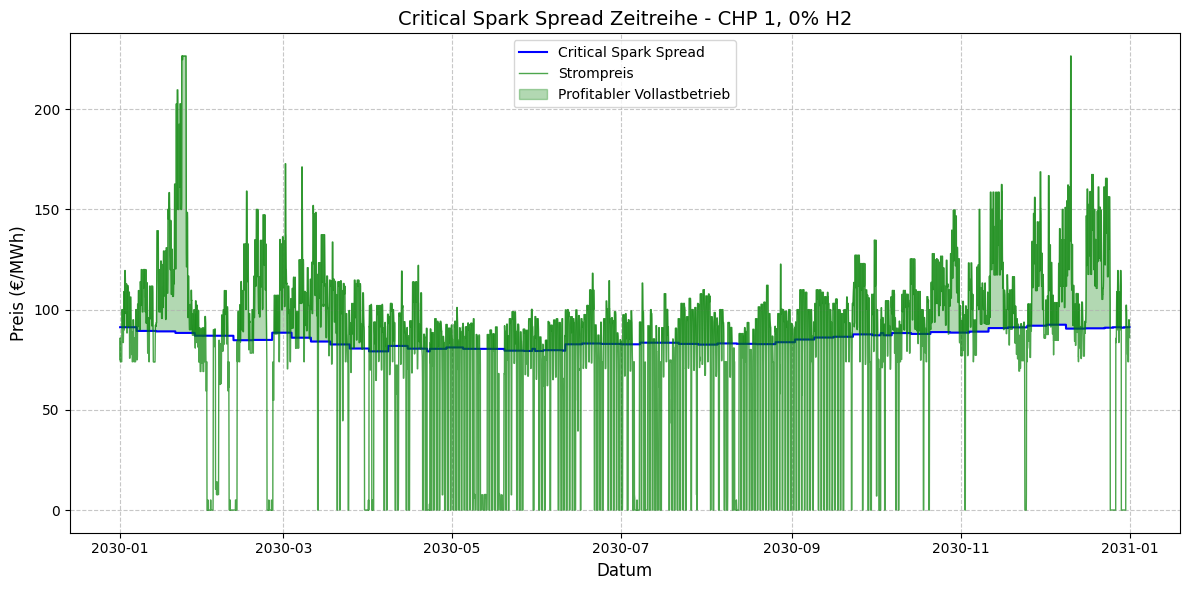


Statistik für Critical Spark Spread - CHP 1, 0% H2:
count    8760.000000
mean       85.320021
std         3.844803
min        79.175753
25%        82.626907
50%        84.888458
75%        88.531964
max        92.479875
Name: critical_spark_spread, dtype: float64
Anteil profitabler Stunden: 5567 von 8760 (63.6%)


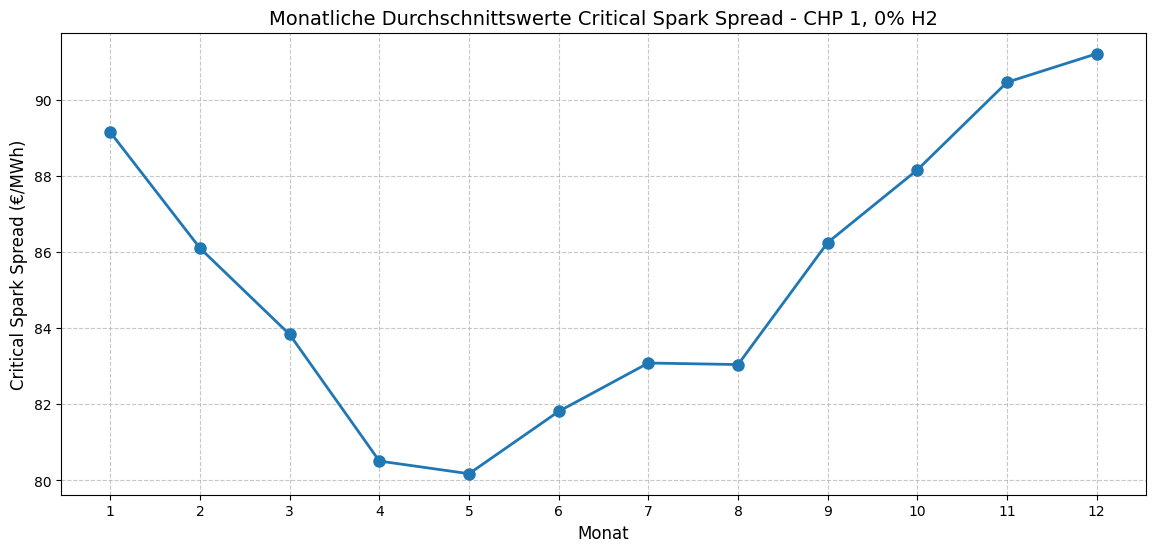

  Analysiere CHP 2...
Verwende CO2-Preis für 2030: 125.0 €/t
Berechnete Energiefraktionen: H2: 0.0000, Erdgas: 1.0000

Erste Zeilen des Ergebnis-DataFrames:
                     electricity_price  min_natural_gas_cost  \
datetime                                                       
2030-01-01 01:00:00              75.01           1535.164242   
2030-01-01 02:00:00              85.88           1535.164242   
2030-01-01 03:00:00              74.00           1535.164242   

                     min_hydrogen_cost  min_fuel_cost  max_natural_gas_cost  \
datetime                                                                      
2030-01-01 01:00:00                0.0    1535.164242           3703.879304   
2030-01-01 02:00:00                0.0    1535.164242           3703.879304   
2030-01-01 03:00:00                0.0    1535.164242           3703.879304   

                     max_hydrogen_cost  max_fuel_cost  min_total_cost  \
datetime                                             

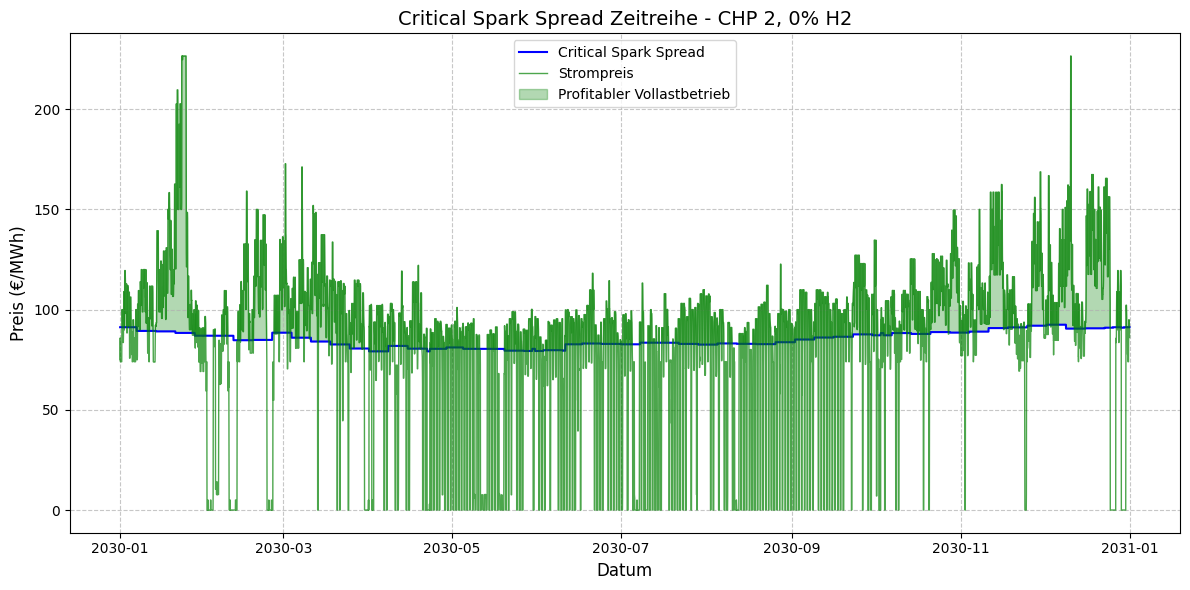


Statistik für Critical Spark Spread - CHP 2, 0% H2:
count    8760.000000
mean       85.320021
std         3.844803
min        79.175753
25%        82.626907
50%        84.888458
75%        88.531964
max        92.479875
Name: critical_spark_spread, dtype: float64
Anteil profitabler Stunden: 5567 von 8760 (63.6%)


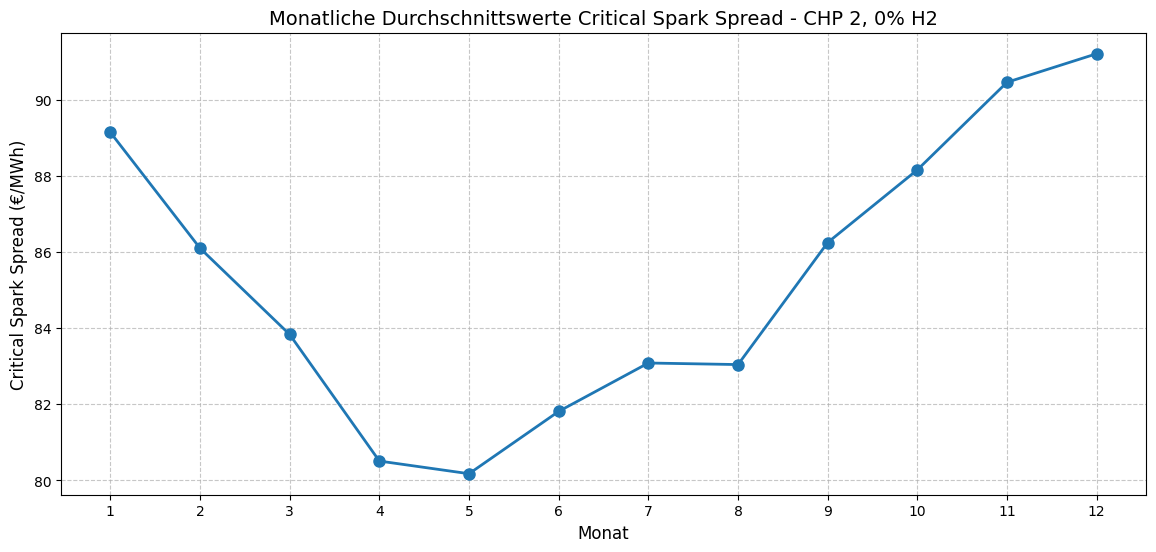


Berechne Critical Spark Spread Zeitreihe für uc1_2030_30h2
  Analysiere CHP 1...
Verwende CO2-Preis für 2030: 125.0 €/t
Berechnete Energiefraktionen: H2: 0.1265, Erdgas: 0.8735

Erste Zeilen des Ergebnis-DataFrames:
                     electricity_price  min_natural_gas_cost  \
datetime                                                       
2030-01-01 01:00:00              75.01           1315.588049   
2030-01-01 02:00:00              85.88           1315.588049   
2030-01-01 03:00:00              74.00           1315.588049   

                     min_hydrogen_cost  min_fuel_cost  max_natural_gas_cost  \
datetime                                                                      
2030-01-01 01:00:00         1501.00712    2816.595169           3174.108657   
2030-01-01 02:00:00         1501.00712    2816.595169           3174.108657   
2030-01-01 03:00:00         1501.00712    2816.595169           3174.108657   

                     max_hydrogen_cost  max_fuel_cost  min_total_c

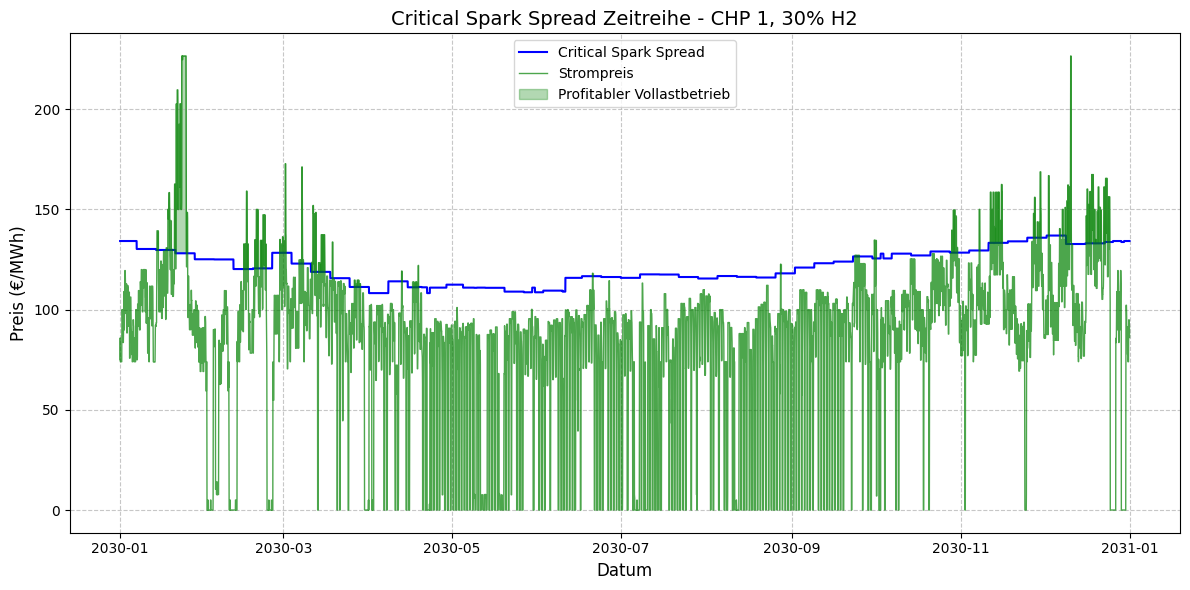


Statistik für Critical Spark Spread - CHP 1, 30% H2:
count    8760.000000
mean      121.510389
std         8.302346
min       108.242654
25%       115.694964
50%       120.578486
75%       128.446158
max       136.971149
Name: critical_spark_spread, dtype: float64
Anteil profitabler Stunden: 683 von 8760 (7.8%)


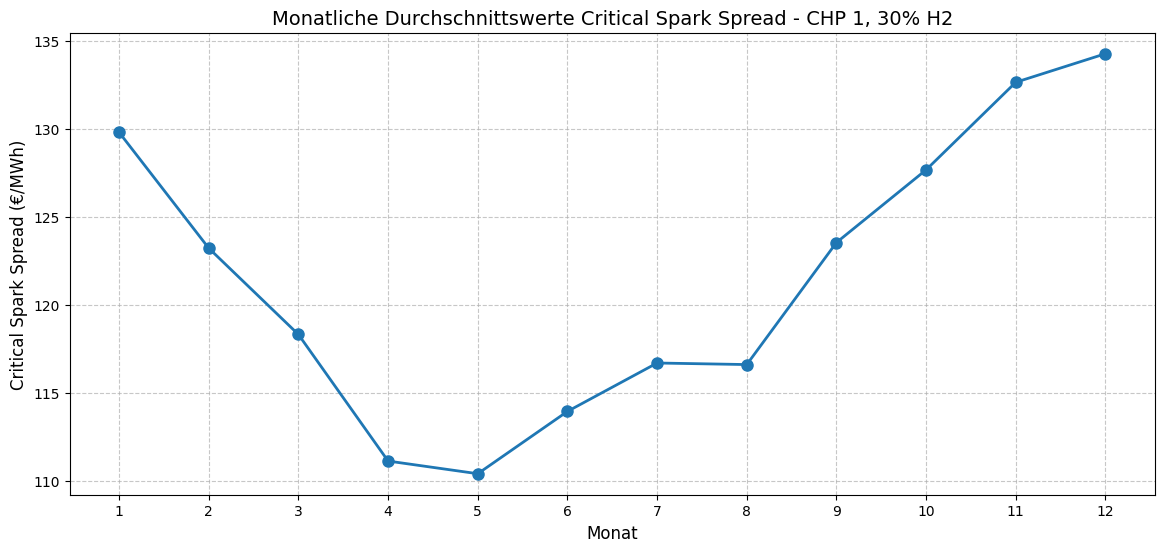

  Analysiere CHP 2...
Verwende CO2-Preis für 2030: 125.0 €/t
Berechnete Energiefraktionen: H2: 0.1265, Erdgas: 0.8735

Erste Zeilen des Ergebnis-DataFrames:
                     electricity_price  min_natural_gas_cost  \
datetime                                                       
2030-01-01 01:00:00              75.01           1315.588049   
2030-01-01 02:00:00              85.88           1315.588049   
2030-01-01 03:00:00              74.00           1315.588049   

                     min_hydrogen_cost  min_fuel_cost  max_natural_gas_cost  \
datetime                                                                      
2030-01-01 01:00:00         1501.00712    2816.595169           3174.108657   
2030-01-01 02:00:00         1501.00712    2816.595169           3174.108657   
2030-01-01 03:00:00         1501.00712    2816.595169           3174.108657   

                     max_hydrogen_cost  max_fuel_cost  min_total_cost  \
datetime                                             

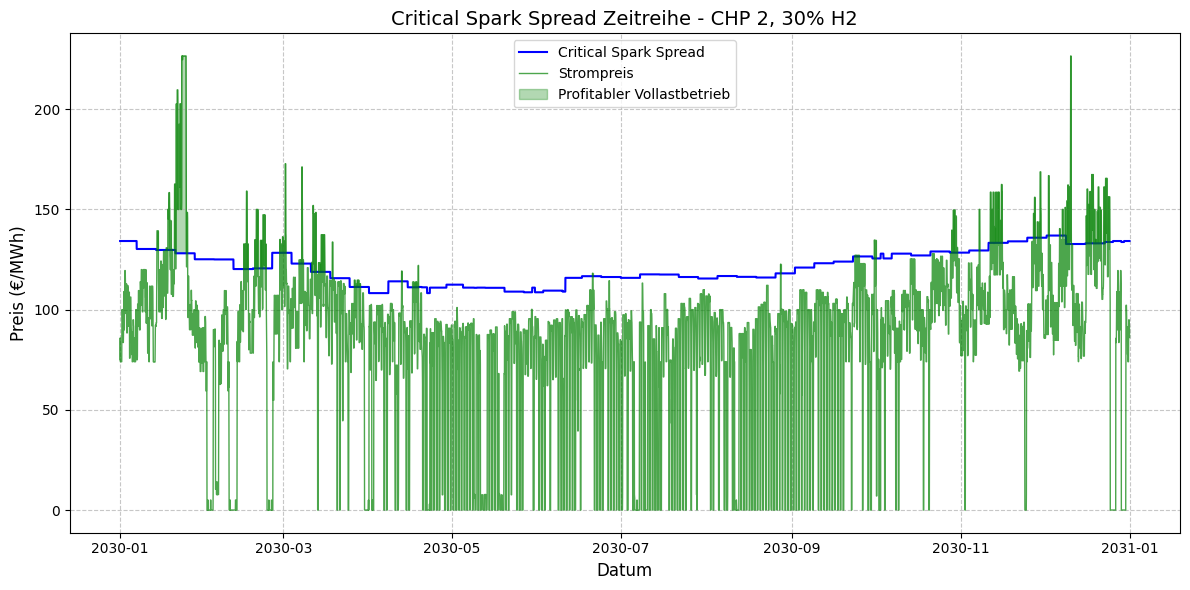


Statistik für Critical Spark Spread - CHP 2, 30% H2:
count    8760.000000
mean      121.510389
std         8.302346
min       108.242654
25%       115.694964
50%       120.578486
75%       128.446158
max       136.971149
Name: critical_spark_spread, dtype: float64
Anteil profitabler Stunden: 683 von 8760 (7.8%)


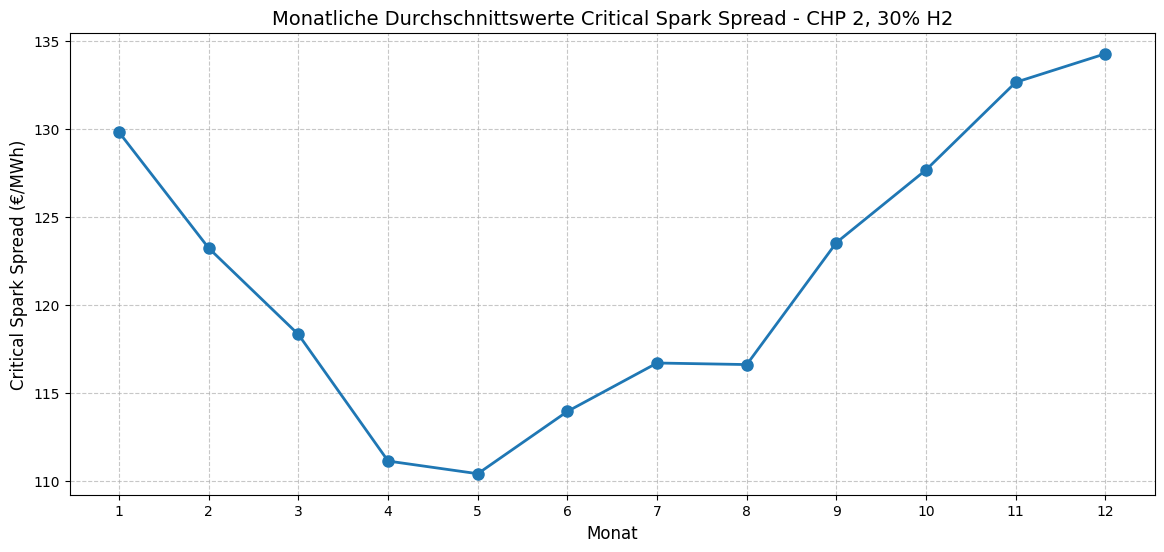


Berechne Critical Spark Spread Zeitreihe für uc1_2030_50h2
  Analysiere CHP 1...
Verwende CO2-Preis für 2030: 125.0 €/t
Berechnete Energiefraktionen: H2: 0.2526, Erdgas: 0.7474

Erste Zeilen des Ergebnis-DataFrames:
                     electricity_price  min_natural_gas_cost  \
datetime                                                       
2030-01-01 01:00:00              75.01           1126.297377   
2030-01-01 02:00:00              85.88           1126.297377   
2030-01-01 03:00:00              74.00           1126.297377   

                     min_hydrogen_cost  min_fuel_cost  max_natural_gas_cost  \
datetime                                                                      
2030-01-01 01:00:00         2998.42155    4124.718927           2717.415331   
2030-01-01 02:00:00         2998.42155    4124.718927           2717.415331   
2030-01-01 03:00:00         2998.42155    4124.718927           2717.415331   

                     max_hydrogen_cost  max_fuel_cost  min_total_c

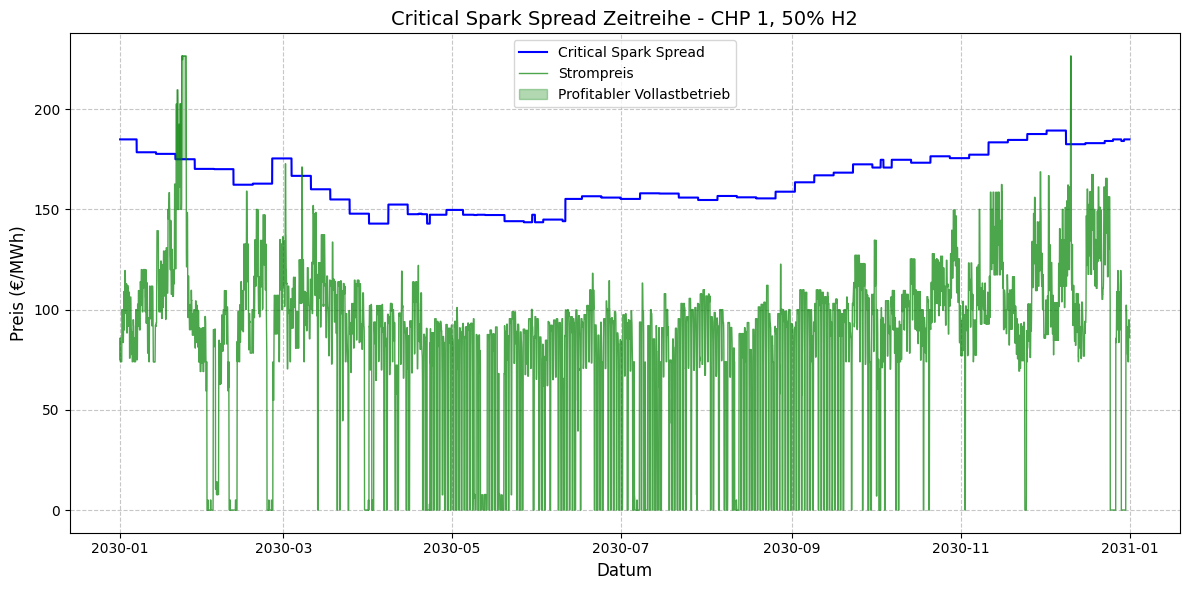


Statistik für Critical Spark Spread - CHP 1, 50% H2:
count    8760.000000
mean      164.377754
std        13.420592
min       142.930700
25%       154.977225
50%       162.871349
75%       175.589299
max       189.369794
Name: critical_spark_spread, dtype: float64
Anteil profitabler Stunden: 68 von 8760 (0.8%)


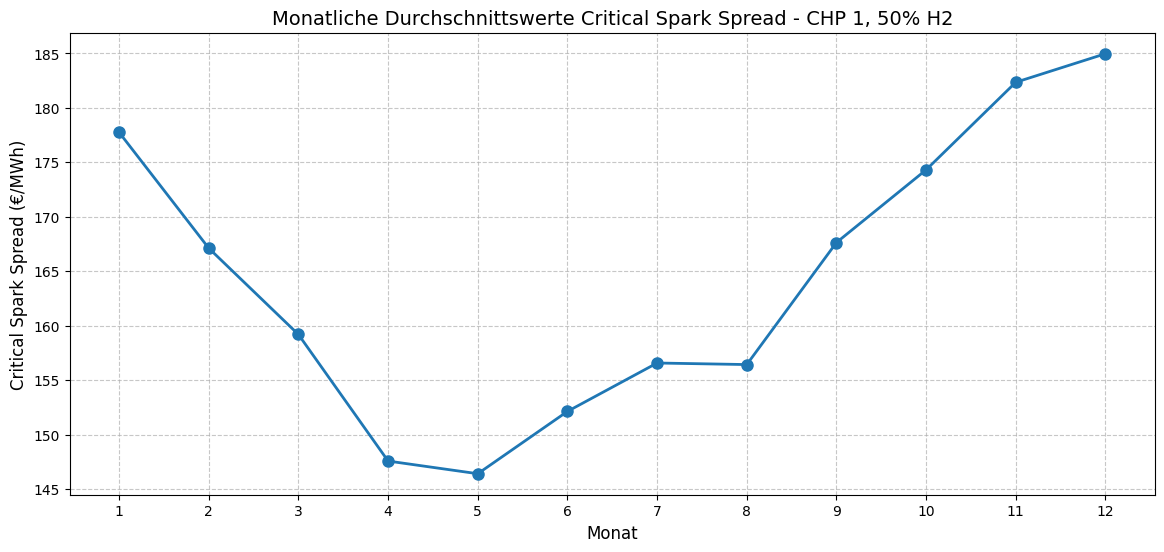

  Analysiere CHP 2...
Verwende CO2-Preis für 2030: 125.0 €/t
Berechnete Energiefraktionen: H2: 0.2526, Erdgas: 0.7474

Erste Zeilen des Ergebnis-DataFrames:
                     electricity_price  min_natural_gas_cost  \
datetime                                                       
2030-01-01 01:00:00              75.01           1126.297377   
2030-01-01 02:00:00              85.88           1126.297377   
2030-01-01 03:00:00              74.00           1126.297377   

                     min_hydrogen_cost  min_fuel_cost  max_natural_gas_cost  \
datetime                                                                      
2030-01-01 01:00:00         2998.42155    4124.718927           2717.415331   
2030-01-01 02:00:00         2998.42155    4124.718927           2717.415331   
2030-01-01 03:00:00         2998.42155    4124.718927           2717.415331   

                     max_hydrogen_cost  max_fuel_cost  min_total_cost  \
datetime                                             

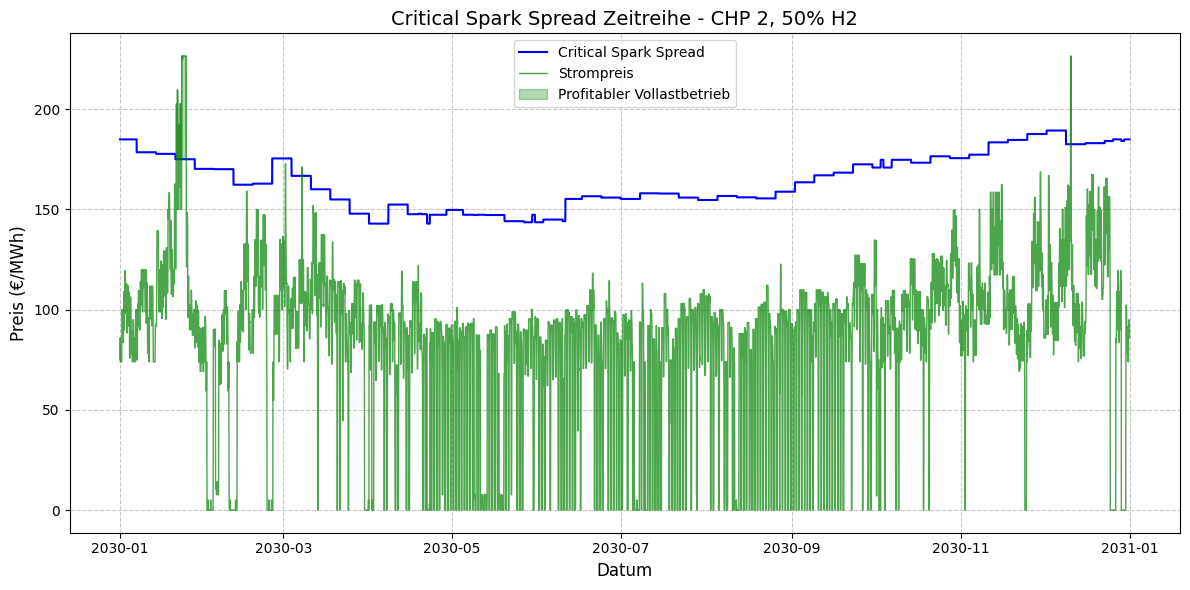


Statistik für Critical Spark Spread - CHP 2, 50% H2:
count    8760.000000
mean      164.377754
std        13.420592
min       142.930700
25%       154.977225
50%       162.871349
75%       175.589299
max       189.369794
Name: critical_spark_spread, dtype: float64
Anteil profitabler Stunden: 68 von 8760 (0.8%)


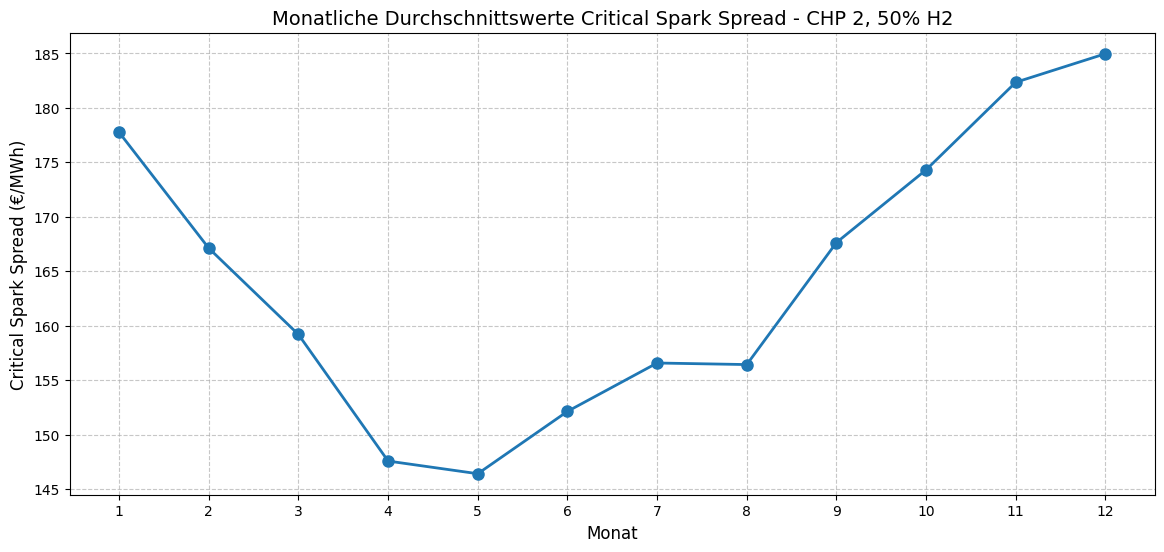


Berechne Critical Spark Spread Zeitreihe für uc1_2030_100h2
  Analysiere CHP 1...
Verwende CO2-Preis für 2030: 125.0 €/t
Berechnete Energiefraktionen: H2: 1.0000, Erdgas: 0.0000

Erste Zeilen des Ergebnis-DataFrames:
                     electricity_price  min_natural_gas_cost  \
datetime                                                       
2030-01-01 01:00:00              75.01                   0.0   
2030-01-01 02:00:00              85.88                   0.0   
2030-01-01 03:00:00              74.00                   0.0   

                     min_hydrogen_cost  min_fuel_cost  max_natural_gas_cost  \
datetime                                                                      
2030-01-01 01:00:00       12066.584136   12066.584136                   0.0   
2030-01-01 02:00:00       12066.584136   12066.584136                   0.0   
2030-01-01 03:00:00       12066.584136   12066.584136                   0.0   

                     max_hydrogen_cost  max_fuel_cost  min_total_

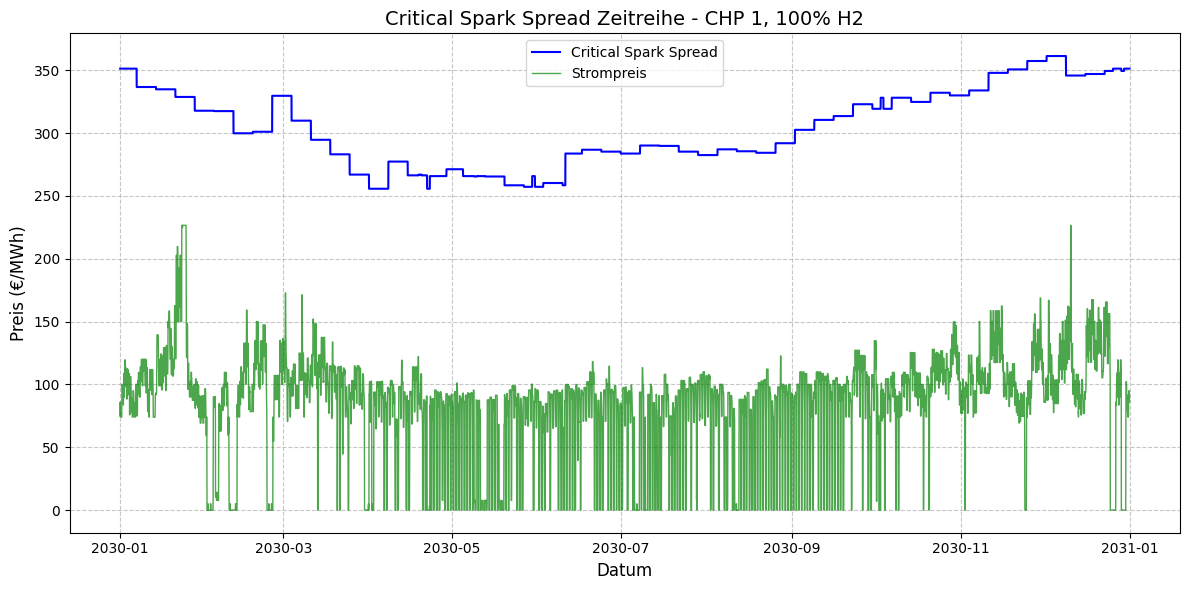


Statistik für Critical Spark Spread - CHP 1, 100% H2:
count    8760.000000
mean      304.434640
std        30.520253
min       255.661116
25%       283.056555
50%       301.008869
75%       329.931219
max       361.269941
Name: critical_spark_spread, dtype: float64
Anteil profitabler Stunden: 0 von 8760 (0.0%)


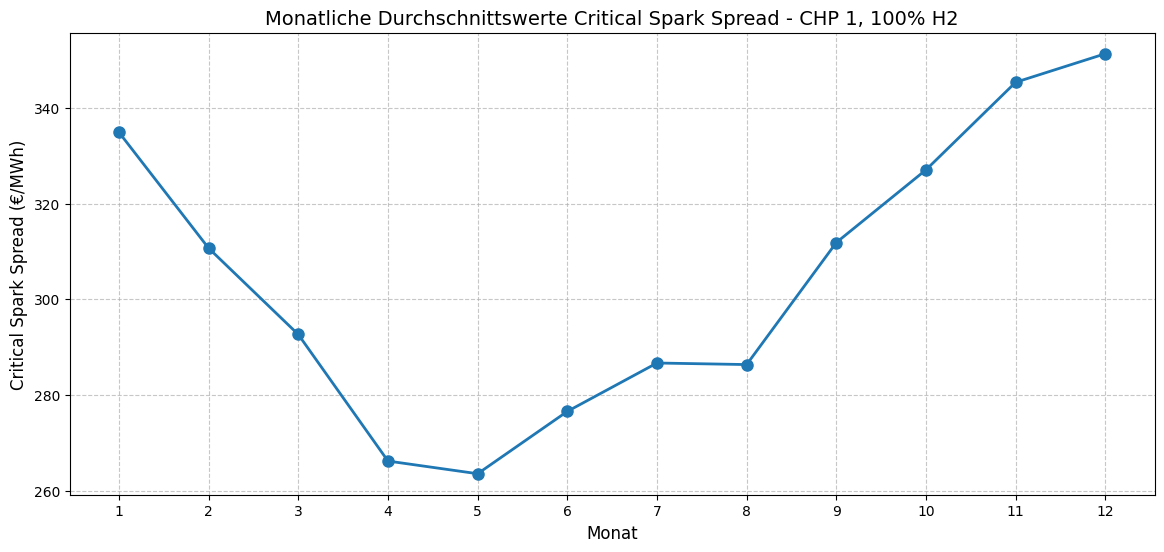

  Analysiere CHP 2...
Verwende CO2-Preis für 2030: 125.0 €/t
Berechnete Energiefraktionen: H2: 1.0000, Erdgas: 0.0000

Erste Zeilen des Ergebnis-DataFrames:
                     electricity_price  min_natural_gas_cost  \
datetime                                                       
2030-01-01 01:00:00              75.01                   0.0   
2030-01-01 02:00:00              85.88                   0.0   
2030-01-01 03:00:00              74.00                   0.0   

                     min_hydrogen_cost  min_fuel_cost  max_natural_gas_cost  \
datetime                                                                      
2030-01-01 01:00:00       12066.584136   12066.584136                   0.0   
2030-01-01 02:00:00       12066.584136   12066.584136                   0.0   
2030-01-01 03:00:00       12066.584136   12066.584136                   0.0   

                     max_hydrogen_cost  max_fuel_cost  min_total_cost  \
datetime                                             

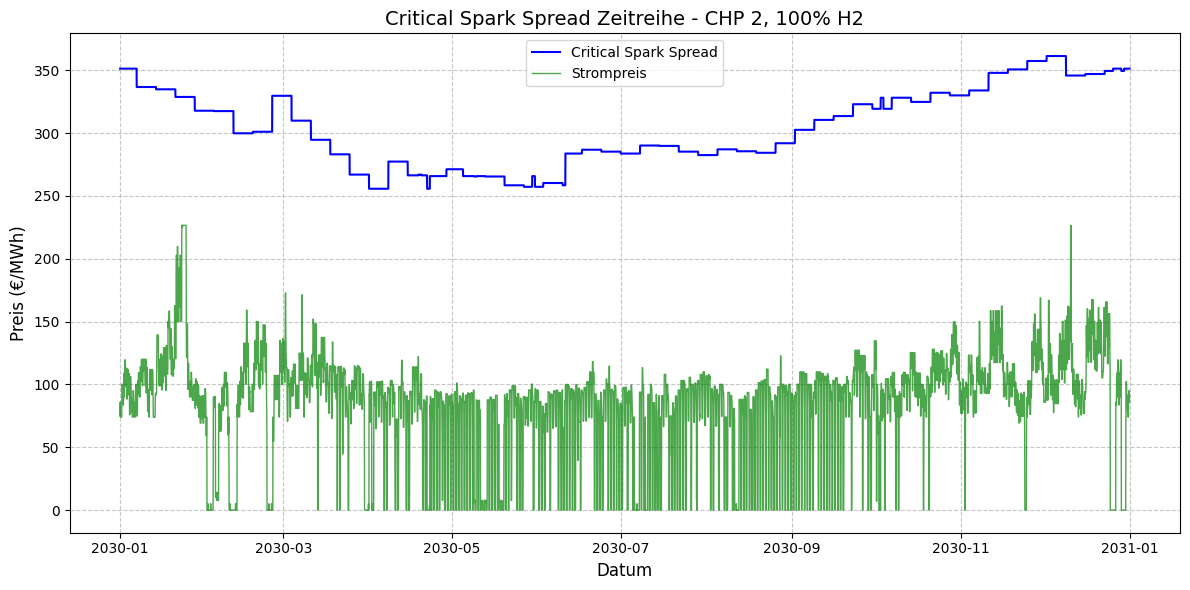


Statistik für Critical Spark Spread - CHP 2, 100% H2:
count    8760.000000
mean      304.434640
std        30.520253
min       255.661116
25%       283.056555
50%       301.008869
75%       329.931219
max       361.269941
Name: critical_spark_spread, dtype: float64
Anteil profitabler Stunden: 0 von 8760 (0.0%)


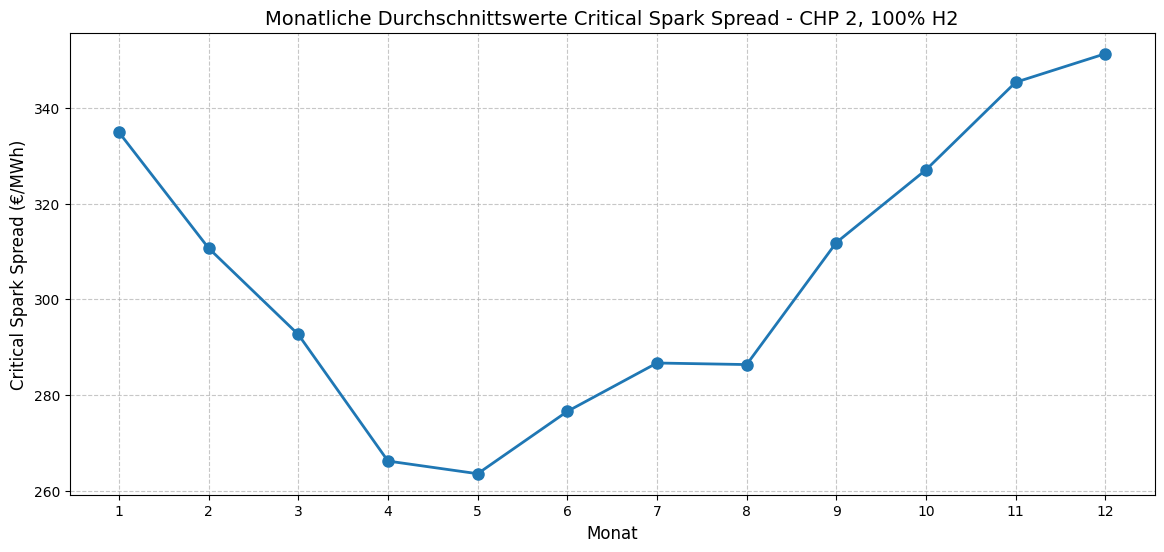

In [297]:
# Aufruf der vereinfachten Analyse
try:
    # Prüfen, ob collection bereits vorverarbeitet wurde
    if 'collection' in locals() and hasattr(collection, 'scenarios') and collection.scenarios:
        # Sicherstellen, dass die Daten vorverarbeitet sind
        collection.preprocess_all().add_datetime_all()
        
        # Testweise für ein einzelnes Szenario ausführen
        for scenario_name, scenario in collection.scenarios.items():
            if scenario_name.startswith(f"{USE_CASE}_{YEAR}_"):
                h2_match = re.search(r'_(\d+)h2', scenario_name)
                if h2_match:
                    h2_admixture = int(h2_match.group(1))
                    if h2_admixture in H2_ADMIXTURES:
                        print(f"\nTeste Critical Spark Spread für {scenario_name}")
                        for chp_unit in ANALYZE_CHP_UNITS:
                            print(f"  Analysiere CHP {chp_unit}...")
                            css_timeseries = calculate_critical_spark_spread_timeseries(
                                scenario, 
                                chp_technical_params, 
                                chp_unit, 
                                h2_admixture, 
                                year=YEAR
                            )
                            
                            if not css_timeseries.empty:
                                print(f"CSS Zeitreihe berechnet, Länge: {len(css_timeseries)}")
                            else:
                                print("Fehler: Leere CSS Zeitreihe")
                        break  # Nur ein Beispiel testen
        
        # Nach erfolgreicher Einzeltestung die vollständige Analyse durchführen
        analyze_critical_spark_spread_timeseries(collection)
    else:
        print("Warnung: Keine Szenarien in der Collection gefunden.")
except Exception as e:
    print(f"Fehler bei der Analyse: {e}")

In [298]:
def calculate_critical_spark_spread(scenario, tech_params, chp_unit, h2_admixture, co2_price=25.0):
    """
    Berechnet den Critical Spark Spread mit Berücksichtigung von CO2-Kosten.
    
    Erweiterte Formel:
    Critical Spark Spread = (Marginale Brennstoffkosten bei höherer Last + CO2-Kosten bei höherer Last 
                           - Marginale Brennstoffkosten bei Mindestlast - CO2-Kosten bei Mindestlast) 
                           / (Zusätzliche Stromerzeugung)
    
    Args:
        scenario: ScenarioData-Objekt mit Simulationsergebnissen
        tech_params: Technische Parameter der CHP-Einheiten
        chp_unit: Die zu analysierende CHP-Einheit (1, 2, etc.)
        h2_admixture: Wasserstoffbeimischungsgrad in Prozent (0, 30, 50, 100)
        co2_price: CO2-Preis in €/Tonne (Standardwert: 25€)
    
    Returns:
        Tuple aus Critical Spark Spread, gemischtem Brennstoffpreis und CO2-Kosten
    """
    # Extrahiere technische Parameter für die angegebene H2-Beimischung
    params = tech_params[h2_admixture]
    
    # Extrahiere Min/Max Brennstoff- und Leistungswerte
    min_gas = params.loc[params['index'] == 'min', 'gas'].values[0]
    max_gas = params.loc[params['index'] == 'max', 'gas'].values[0]
    min_power = params.loc[params['index'] == 'min', 'power'].values[0]
    max_power = params.loc[params['index'] == 'max', 'power'].values[0]
    
    # Zugriff auf das Dataframe mit den Simulationsergebnissen
    df = scenario.processed_output
    
    # Extrahiere tatsächliche Brennstoffpreise aus dem Szenario (€/MWh)
    h2_price_values = df['hydrogen_price'].unique()
    gas_price_values = df['gas_price'].unique()
    
    if len(h2_price_values) == 0 or len(gas_price_values) == 0:
        print(f"Warnung: Keine Preisdaten für Szenario {scenario.scenario_name} gefunden")
        return None, None, None
    
    # Falls CO2-Preis im Szenario verfügbar ist, diesen verwenden
    if 'co2_price' in df.columns:
        co2_price_values = df['co2_price'].unique()
        if len(co2_price_values) > 0:
            co2_price = co2_price_values.mean()
            print(f"CO2-Preis aus Szenario: {co2_price:.2f} €/t")
    
    # Wir verwenden den Durchschnitt, falls die Preise zeitvariabel sind
    h2_price = h2_price_values.mean() 
    gas_price = gas_price_values.mean()
    
    print(f"Extrahierte Preise: H2: {h2_price:.2f} €/MWh, Gas: {gas_price:.2f} €/MWh, CO2: {co2_price:.2f} €/t")
    
    # Berechne gemischten Brennstoffpreis basierend auf H2-Beimischungsgrad
    h2_ratio = h2_admixture / 100
    blended_price = h2_price * h2_ratio + gas_price * (1 - h2_ratio)
    
    # CO2-Emissionsfaktoren (tCO2/MWh)
    # Wasserstoff hat keine direkten CO2-Emissionen, Erdgas ca. 0.2 tCO2/MWh
    gas_emission_factor = 0.2  # tCO2/MWh für Erdgas
    
    # Bei höherem Wasserstoffanteil sinken die CO2-Emissionen proportional
    blended_emission_factor = gas_emission_factor * (1 - h2_ratio)
    
    # CO2-Emissionen bei Min- und Maxlast (in Tonnen)
    min_co2_emissions = min_gas * blended_emission_factor
    max_co2_emissions = max_gas * blended_emission_factor
    
    # CO2-Kosten bei Min- und Maxlast (€)
    min_co2_cost = min_co2_emissions * co2_price
    max_co2_cost = max_co2_emissions * co2_price
    
    # Berechne Brennstoffkosten bei Min- und Maxlast
    min_fuel_cost = min_gas * blended_price
    max_fuel_cost = max_gas * blended_price
    
    # Gesamtkosten (Brennstoff + CO2)
    min_total_cost = min_fuel_cost + min_co2_cost
    max_total_cost = max_fuel_cost + max_co2_cost
    
    # Berechne zusätzliche Kosten und Leistung
    additional_total_cost = max_total_cost - min_total_cost
    additional_power = max_power - min_power
    
    # Berechne Critical Spark Spread mit CO2-Kosten
    critical_spark_spread = additional_total_cost / additional_power
    
    # CO2-Kosten pro MWh Strom
    min_co2_cost_per_mwh = min_co2_cost / min_power
    max_co2_cost_per_mwh = max_co2_cost / max_power
    avg_co2_cost_per_mwh = (min_co2_cost_per_mwh + max_co2_cost_per_mwh) / 2
    
    print(f"CO2-Kosten: {min_co2_cost_per_mwh:.2f} €/MWh (Teillast), {max_co2_cost_per_mwh:.2f} €/MWh (Volllast)")
    print(f"Critical Spark Spread mit CO2: {critical_spark_spread:.2f} €/MWh")
    
    return critical_spark_spread, blended_price, avg_co2_cost_per_mwh


Analysiere Critical Spark Spread (mit CO2) für uc1_2030_0h2
Extrahierte Preise: H2: 162.59 €/MWh, Gas: 20.64 €/MWh, CO2: 50.00 €/t
CO2-Kosten: 48.32 €/MWh (Teillast), 25.04 €/MWh (Volllast)
Critical Spark Spread mit CO2: 57.22 €/MWh
  CHP 1: Critical Spark Spread = 57.22 €/MWh
  Brennstoffpreis: 20.64 €/MWh, CO2-Kosten: 36.68 €/MWh
  El. Wirkungsgrad: 20.7% (Teillast) vs 39.9% (Volllast)
Extrahierte Preise: H2: 162.59 €/MWh, Gas: 20.64 €/MWh, CO2: 50.00 €/t
CO2-Kosten: 48.32 €/MWh (Teillast), 25.04 €/MWh (Volllast)
Critical Spark Spread mit CO2: 57.22 €/MWh
  CHP 2: Critical Spark Spread = 57.22 €/MWh
  Brennstoffpreis: 20.64 €/MWh, CO2-Kosten: 36.68 €/MWh
  El. Wirkungsgrad: 20.7% (Teillast) vs 39.9% (Volllast)

Analysiere Critical Spark Spread (mit CO2) für uc1_2030_30h2
Extrahierte Preise: H2: 162.59 €/MWh, Gas: 20.64 €/MWh, CO2: 50.00 €/t
CO2-Kosten: 39.06 €/MWh (Teillast), 20.24 €/MWh (Volllast)
Critical Spark Spread mit CO2: 151.43 €/MWh
  CHP 1: Critical Spark Spread = 151.43 €

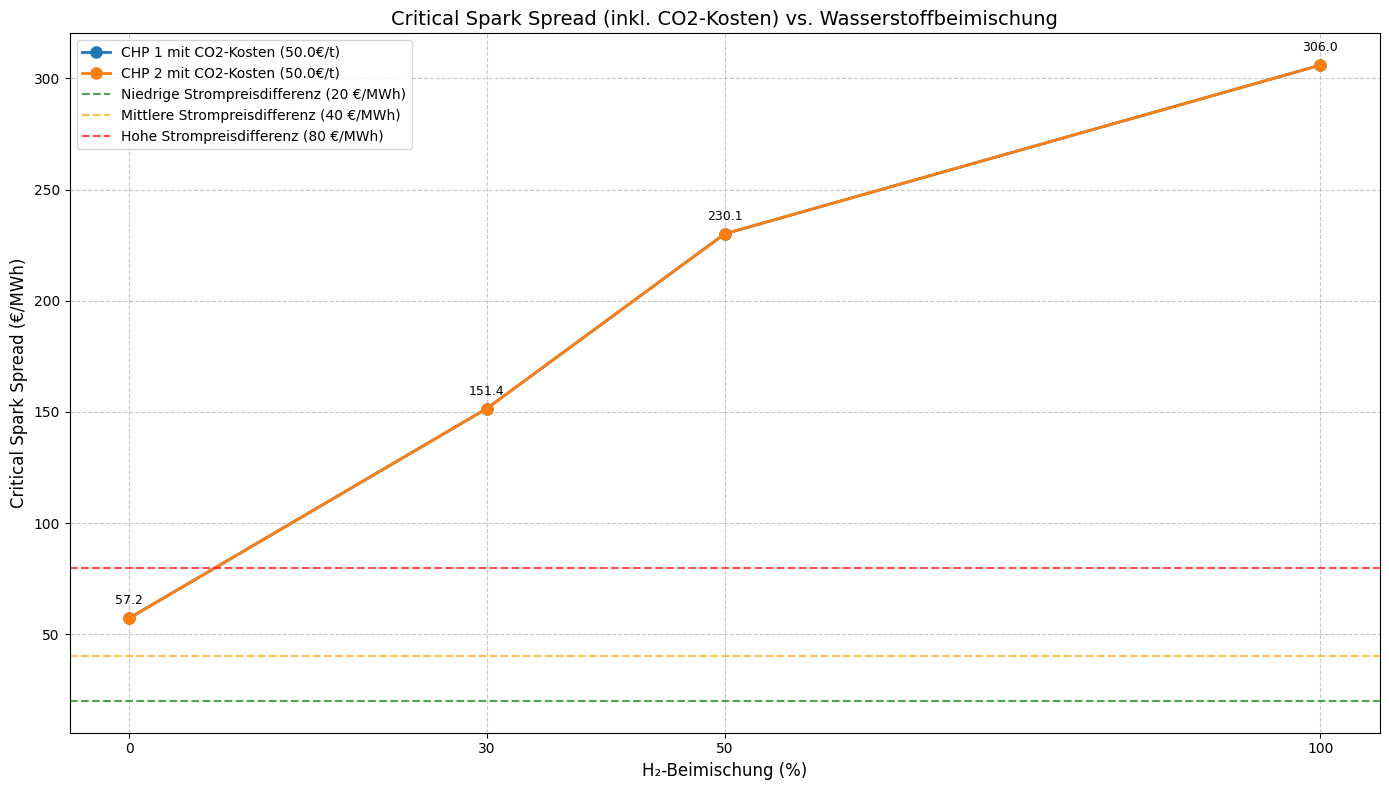

In [299]:
def analyze_critical_spark_spread_with_co2(collection, chp_units=ANALYZE_CHP_UNITS, h2_admixtures=H2_ADMIXTURES, co2_price=25.0):
    """Führt eine Critical Spark Spread Analyse mit CO2-Kosten für alle Szenarien durch."""
    results = []
    
    for scenario_name, scenario in collection.scenarios.items():
        if not scenario_name.startswith(f"{USE_CASE}_{YEAR}_"):
            continue
            
        # H2-Beimischung aus dem Namen extrahieren
        h2_match = re.search(r'_(\d+)h2', scenario_name)
        if not h2_match:
            print(f"Warnung: Konnte H2-Beimischung nicht aus '{scenario_name}' extrahieren")
            continue
            
        h2_admixture = int(h2_match.group(1))
        if h2_admixture not in h2_admixtures:
            continue
            
        print(f"\nAnalysiere Critical Spark Spread (mit CO2) für {scenario_name}")
        
        # Für jede CHP-Einheit analysieren
        for chp_unit in chp_units:
            css, blended_price, co2_cost = calculate_critical_spark_spread(
                scenario, chp_technical_params, chp_unit, h2_admixture, co2_price)
            
            if css is not None:
                # Extrahiere relevante technische Parameter für Kontext
                params = chp_technical_params[h2_admixture]
                min_power = params.loc[params['index'] == 'min', 'power'].values[0]
                max_power = params.loc[params['index'] == 'max', 'power'].values[0]
                min_gas = params.loc[params['index'] == 'min', 'gas'].values[0]
                max_gas = params.loc[params['index'] == 'max', 'gas'].values[0]
                
                min_eff = min_power / min_gas * 100
                max_eff = max_power / max_gas * 100
                
                results.append({
                    'scenario': scenario_name,
                    'chp_unit': chp_unit,
                    'h2_admixture': h2_admixture,
                    'critical_spark_spread': css,
                    'blended_fuel_price': blended_price,
                    'co2_cost_per_mwh': co2_cost,
                    'min_electrical_efficiency': min_eff,
                    'max_electrical_efficiency': max_eff,
                    'efficiency_ratio': min_eff / max_eff
                })
                
                print(f"  CHP {chp_unit}: Critical Spark Spread = {css:.2f} €/MWh")
                print(f"  Brennstoffpreis: {blended_price:.2f} €/MWh, CO2-Kosten: {co2_cost:.2f} €/MWh")
                print(f"  El. Wirkungsgrad: {min_eff:.1f}% (Teillast) vs {max_eff:.1f}% (Volllast)")
    
    return pd.DataFrame(results)

# Ausführen der Analyse mit CO2-Kosten
co2_price = 50.0  # Angenommener CO2-Preis in €/Tonne
spark_spread_results_with_co2 = analyze_critical_spark_spread_with_co2(collection, co2_price=co2_price)

# Visualisierung der Ergebnisse
if not spark_spread_results_with_co2.empty:
    # Vergleich mit/ohne CO2-Kosten
    plt.figure(figsize=(14, 8))
    
    for chp_unit in spark_spread_results_with_co2['chp_unit'].unique():
        unit_data = spark_spread_results_with_co2[spark_spread_results_with_co2['chp_unit'] == chp_unit]
        unit_data = unit_data.sort_values('h2_admixture')
        
        plt.plot(unit_data['h2_admixture'], unit_data['critical_spark_spread'], 
                'o-', linewidth=2, markersize=8, 
                label=f'CHP {int(chp_unit)} mit CO2-Kosten ({co2_price}€/t)',
                color=plt.cm.tab10(int(chp_unit)-1))
        
    # Datenpunkte beschriften
    for x, y in zip(unit_data['h2_admixture'], unit_data['critical_spark_spread']):
        plt.annotate(f'{y:.1f}', (x, y), textcoords="offset points", 
                    xytext=(0,10), ha='center', fontsize=9)
    
    # Referenzlinien für typische Strompreisdifferenzen
    plt.axhline(y=20, color='green', linestyle='--', alpha=0.7, label='Niedrige Strompreisdifferenz (20 €/MWh)')
    plt.axhline(y=40, color='orange', linestyle='--', alpha=0.7, label='Mittlere Strompreisdifferenz (40 €/MWh)')
    plt.axhline(y=80, color='red', linestyle='--', alpha=0.7, label='Hohe Strompreisdifferenz (80 €/MWh)')
    
    plt.title(f'Critical Spark Spread (inkl. CO2-Kosten) vs. Wasserstoffbeimischung', fontsize=14)
    plt.xlabel('H₂-Beimischung (%)', fontsize=12)
    plt.ylabel('Critical Spark Spread (€/MWh)', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(fontsize=10)
    plt.xticks(spark_spread_results_with_co2['h2_admixture'].unique())
    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_PATH, f'critical_spark_spread_with_co2_{USE_CASE}_{YEAR}.png'), dpi=300)
    plt.show()

In [ ]:
def summarize_findings(results_df):
    """Erstellt eine textuelle Zusammenfassung der Analyse."""
    if results_df.empty:
        print("Keine Daten für die Zusammenfassung verfügbar.")
        return
    
    print("\n==== ZUSAMMENFASSUNG DER CHP-ANALYSE ====")
    print(f"Use Case: {USE_CASE.upper()}, Jahr: {YEAR}")
    print(f"Analysierte H2-Beimischungen: {sorted(results_df['h2_admixture'].unique())}")
    print(f"Analysierte CHP-Einheiten: {sorted(results_df['chp_unit'].unique())}")
    
    # Analyse der Teillast-Anteile
    print("\n1. TEILLASTANTEILE")
    for chp_unit in sorted(results_df['chp_unit'].unique()):
        print(f"\nCHP {int(chp_unit)}:")
        unit_data = results_df[results_df['chp_unit'] == chp_unit].sort_values('h2_admixture')
        
        for _, row in unit_data.iterrows():
            print(f"  {row['h2_admixture']}% H2: {row['part_load_percent']:.1f}% Teillast, "
                  f"{row['operating_hours']} Betriebsstunden ({row['operating_percent']:.1f}% der Zeit)")
    
    # Analyse der Wirkungsgrade
    print("\n2. WIRKUNGSGRADE")
    for chp_unit in sorted(results_df['chp_unit'].unique()):
        print(f"\nCHP {int(chp_unit)}:")
        unit_data = results_df[results_df['chp_unit'] == chp_unit].sort_values('h2_admixture')
        
        for _, row in unit_data.iterrows():
            print(f"  {row['h2_admixture']}% H2:")
            print(f"    Elektrisch: {row['el_eff_part']:.1f}% (Teillast) vs. {row['el_eff_full']:.1f}% (Volllast), "
                  f"Verhältnis: {(row['el_eff_part']/row['el_eff_full']*100):.1f}%")
            print(f"    Gesamt: {row['total_eff_part']:.1f}% (Teillast) vs. {row['total_eff_full']:.1f}% (Volllast), "
                  f"Differenz: {(row['total_eff_full']-row['total_eff_part']):.1f} Prozentpunkte")
    
    # Vergleich 0% vs. 100% H2
    print("\n3. VERGLEICH 0% vs. 100% H2")
    if 0 in results_df['h2_admixture'].values and 100 in results_df['h2_admixture'].values:
        for chp_unit in sorted(results_df['chp_unit'].unique()):
            h0_data = results_df[(results_df['chp_unit'] == chp_unit) & (results_df['h2_admixture'] == 0)]
            h100_data = results_df[(results_df['chp_unit'] == chp_unit) & (results_df['h2_admixture'] == 100)]
            
            if not h0_data.empty and not h100_data.empty:
                h0 = h0_data.iloc[0]
                h100 = h100_data.iloc[0]
                
                print(f"\nCHP {int(chp_unit)}:")
                print(f"  Teillastanteil: {h0['part_load_percent']:.1f}% (0% H2) → {h100['part_load_percent']:.1f}% (100% H2), "
                      f"Änderung: {(h100['part_load_percent']-h0['part_load_percent']):.1f} Prozentpunkte")
                
                print(f"  Elektrischer Wirkungsgrad (Teillast): {h0['el_eff_part']:.1f}% → {h100['el_eff_part']:.1f}%, "
                      f"Änderung: {(h100['el_eff_part']-h0['el_eff_part']):.1f} Prozentpunkte")
                
                print(f"  Elektrischer Wirkungsgrad (Volllast): {h0['el_eff_full']:.1f}% → {h100['el_eff_full']:.1f}%, "
                      f"Änderung: {(h100['el_eff_full']-h0['el_eff_full']):.1f} Prozentpunkte")
                
                ratio_0 = h0['el_eff_part'] / h0['el_eff_full'] if h0['el_eff_full'] > 0 else 0
                ratio_100 = h100['el_eff_part'] / h100['el_eff_full'] if h100['el_eff_full'] > 0 else 0
                
                print(f"  Verhältnis el. Wirkungsgrad Teillast/Volllast: {ratio_0:.3f} → {ratio_100:.3f}, "
                      f"Änderung: {(ratio_100-ratio_0):.3f}")
                
                diff_0 = h0['total_eff_full'] - h0['total_eff_part']
                diff_100 = h100['total_eff_full'] - h100['total_eff_part']
                
                print(f"  Gesamtwirkungsgrad-Differenz (Volllast-Teillast): {diff_0:.1f} → {diff_100:.1f} Prozentpunkte, "
                      f"Änderung: {(diff_100-diff_0):.1f} Prozentpunkte")
    
    # Schlussfolgerungen
    print("\n4. SCHLUSSFOLGERUNGEN")
    
    # Prüfen, ob der Teillastanteil bei 100% H2 höher ist
    higher_part_load_at_100 = False
    if 0 in results_df['h2_admixture'].values and 100 in results_df['h2_admixture'].values:
        for chp_unit in sorted(results_df['chp_unit'].unique()):
            h0_data = results_df[(results_df['chp_unit'] == chp_unit) & (results_df['h2_admixture'] == 0)]
            h100_data = results_df[(results_df['chp_unit'] == chp_unit) & (results_df['h2_admixture'] == 100)]
            
            if not h0_data.empty and not h100_data.empty:
                if h100_data.iloc[0]['part_load_percent'] > h0_data.iloc[0]['part_load_percent']:
                    higher_part_load_at_100 = True
                    break
    
    if higher_part_load_at_100:
        print("• Bei 100% H2-Beimischung wird tatsächlich ein höherer Teillastanteil bevorzugt.")
        print("  Dies bestätigt die These, dass sich bei höheren H2-Beimischungen andere Lastbereiche lohnen.")
    else:
        print("• Es konnte keine eindeutige Bevorzugung von Teillastbetrieb bei 100% H2-Beimischung festgestellt werden.")
    
    # Überprüfe Wirkungsgradunterschiede
    better_teillast_efficiency_at_100 = False
    if 0 in results_df['h2_admixture'].values and 100 in results_df['h2_admixture'].values:
        for chp_unit in sorted(results_df['chp_unit'].unique()):
            h0_data = results_df[(results_df['chp_unit'] == chp_unit) & (results_df['h2_admixture'] == 0)]
            h100_data = results_df[(results_df['chp_unit'] == chp_unit) & (results_df['h2_admixture'] == 100)]
            
            if not h0_data.empty and not h100_data.empty:
                h0 = h0_data.iloc[0]
                h100 = h100_data.iloc[0]
                
                ratio_0 = h0['el_eff_part'] / h0['el_eff_full'] if h0['el_eff_full'] > 0 else 0
                ratio_100 = h100['el_eff_part'] / h100['el_eff_full'] if h100['el_eff_full'] > 0 else 0
                
                if ratio_100 > ratio_0:
                    better_teillast_efficiency_at_100 = True
                    break
    
    if better_teillast_efficiency_at_100:
        print("• Die relativen Wirkungsgrade bei Teillast sind bei 100% H2 besser als bei 0% H2.")
        print("  Das bedeutet, dass der Wirkungsgradverlust bei Teillastbetrieb mit 100% H2 geringer ist.")
    else:
        print("• Es konnte keine eindeutige Verbesserung der relativen Teillastwirkungsgrade bei 100% H2 festgestellt werden.")
    
    print("\n• Die genaue Betriebsstrategie wird durch viele Faktoren beeinflusst, darunter:")
    print("  - Die spezifischen Wirkungsgradkurven bei verschiedenen H2-Beimischungen")
    print("  - Die zeitlichen Verläufe von Strom- und Gaspreisen")
    print("  - Die Anforderungen des Wärmenetzes und die Strommarktbedingungen")
    print("==== ENDE DER ZUSAMMENFASSUNG ====")

# Zusammenfassung der Ergebnisse
if 'results_df' in locals() and not results_df.empty:
    summarize_findings(results_df)


==== ZUSAMMENFASSUNG DER CHP-ANALYSE ====
Use Case: UC1, Jahr: 2030
Analysierte H2-Beimischungen: [np.int64(0), np.int64(30), np.int64(50), np.int64(100)]
Analysierte CHP-Einheiten: [np.int64(1), np.int64(2)]

1. TEILLASTANTEILE

CHP 1:
  0% H2: 6.7% Teillast, 3302 Betriebsstunden (37.7% der Zeit)
  30% H2: 11.9% Teillast, 4131 Betriebsstunden (47.2% der Zeit)
  50% H2: 10.6% Teillast, 4523 Betriebsstunden (51.6% der Zeit)
  100% H2: 91.4% Teillast, 5744 Betriebsstunden (65.6% der Zeit)

CHP 2:
  0% H2: 6.5% Teillast, 2960 Betriebsstunden (33.8% der Zeit)
  30% H2: 10.5% Teillast, 4098 Betriebsstunden (46.8% der Zeit)
  50% H2: 9.1% Teillast, 4437 Betriebsstunden (50.7% der Zeit)
  100% H2: 91.6% Teillast, 5744 Betriebsstunden (65.6% der Zeit)

2. WIRKUNGSGRADE

CHP 1:
  0% H2:
    Elektrisch: 20.8% (Teillast) vs. 39.9% (Volllast), Verhältnis: 52.1%
    Gesamt: 84.5% (Teillast) vs. 92.4% (Volllast), Differenz: 7.9 Prozentpunkte
  30% H2:
    Elektrisch: 19.6% (Teillast) vs. 34.5% (Vol

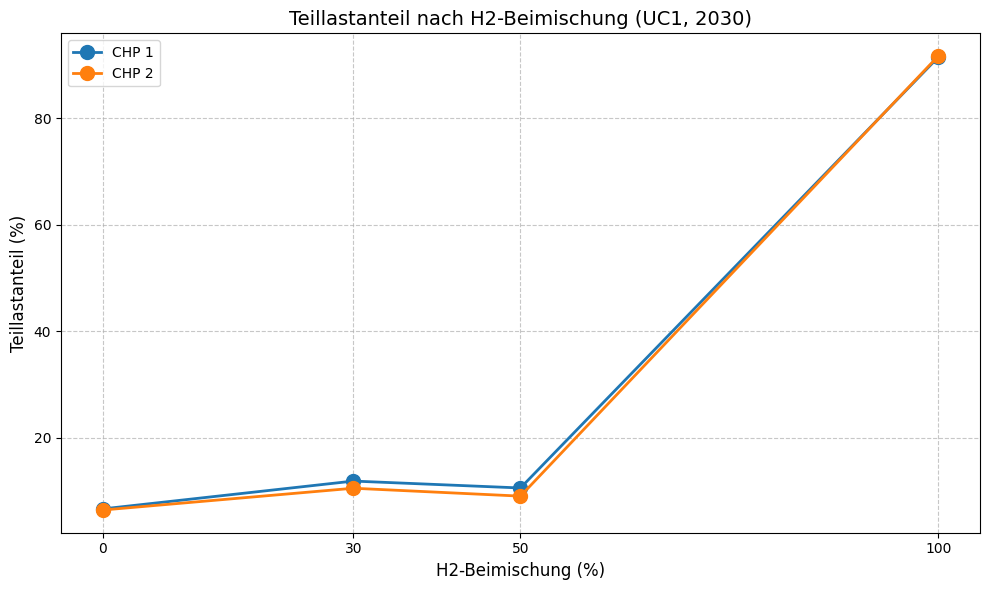

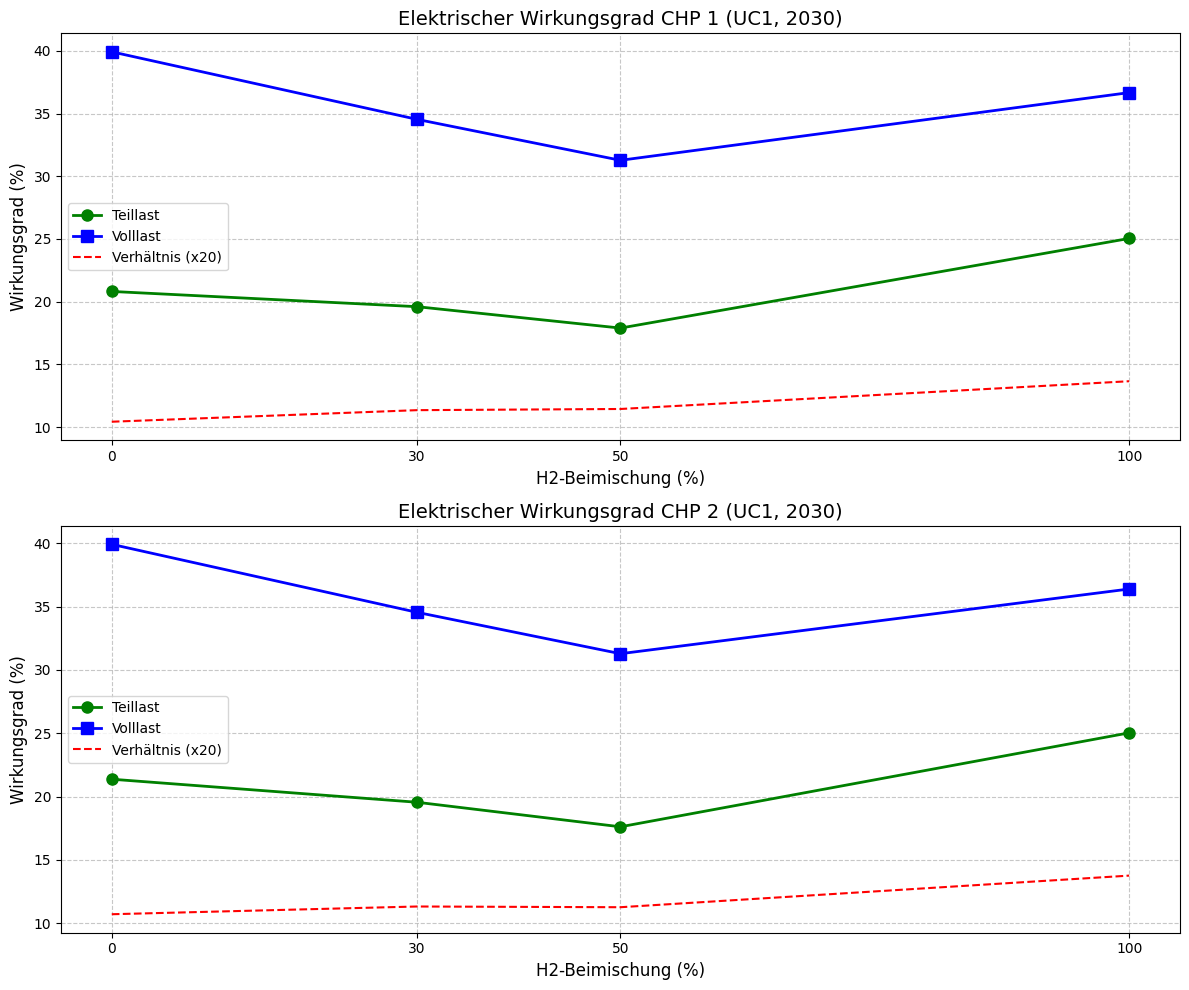

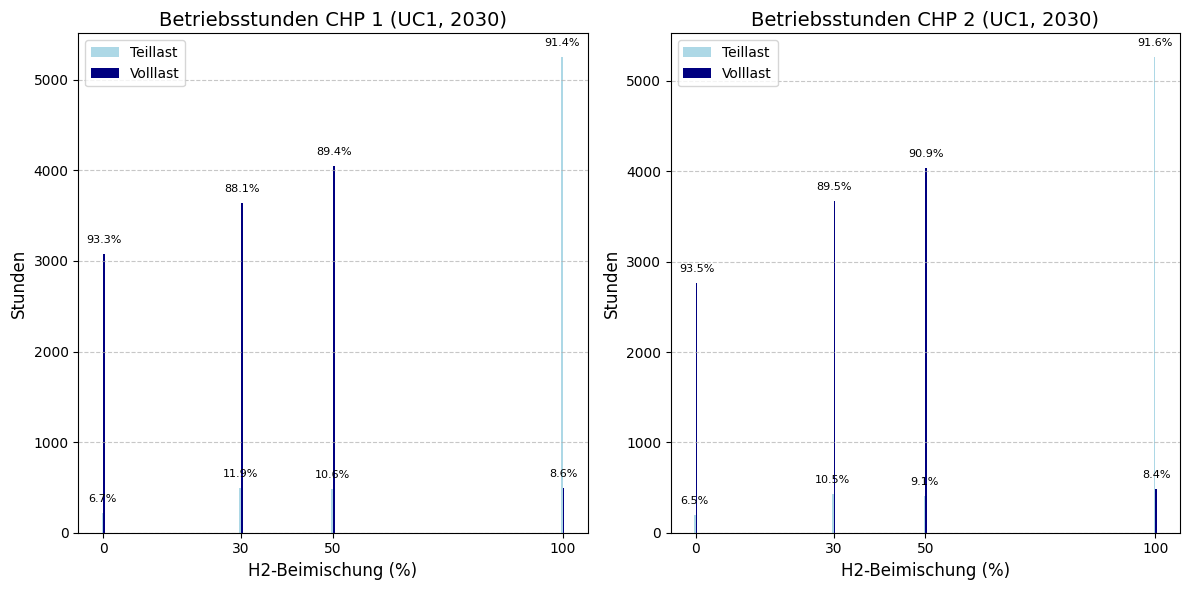

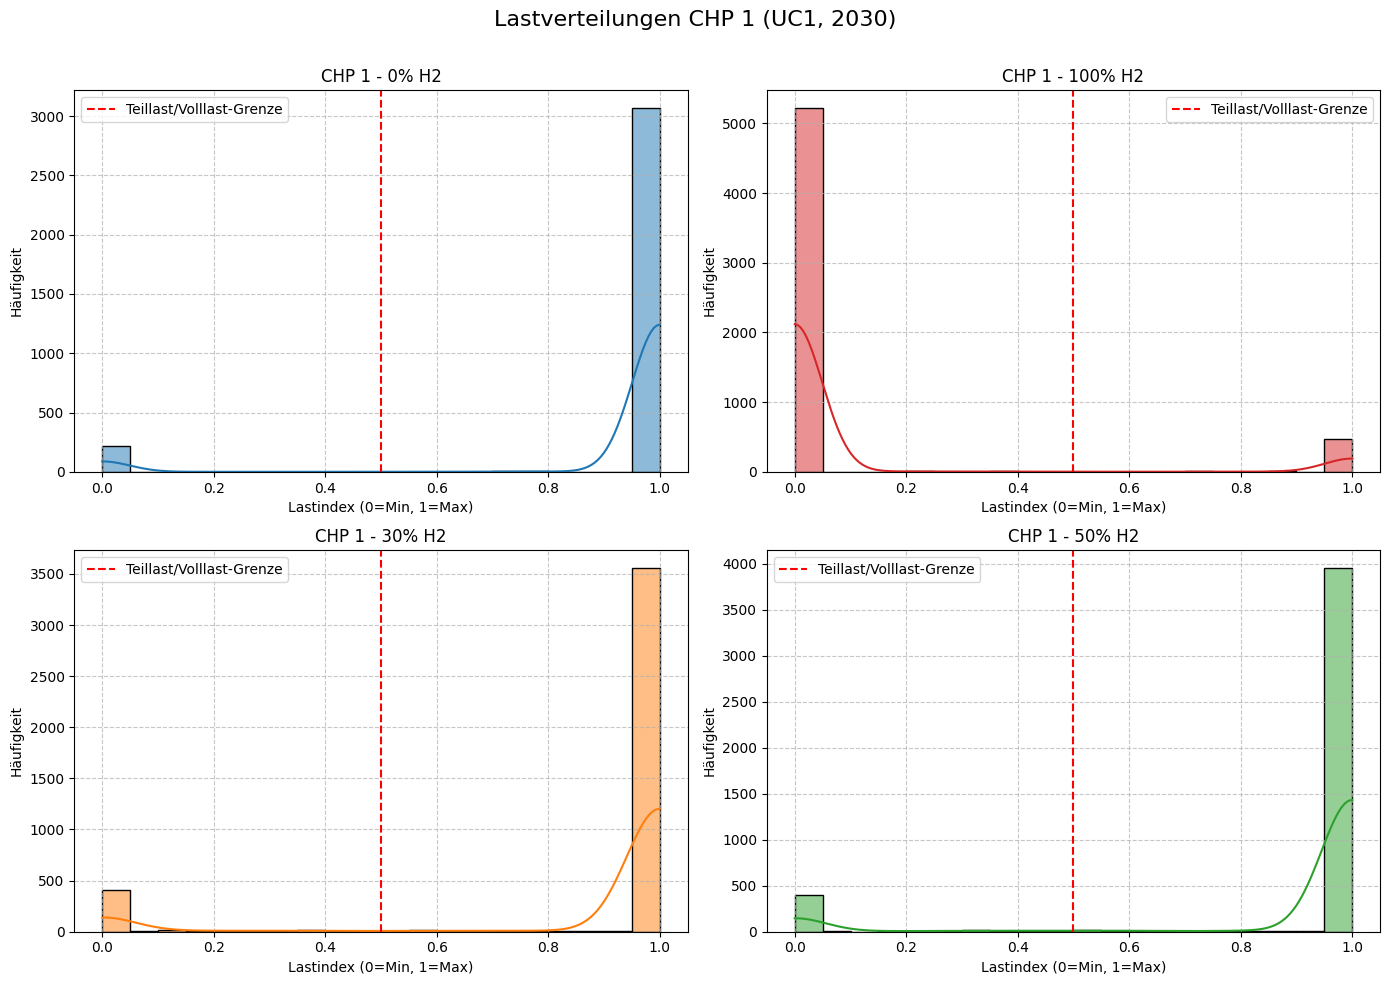

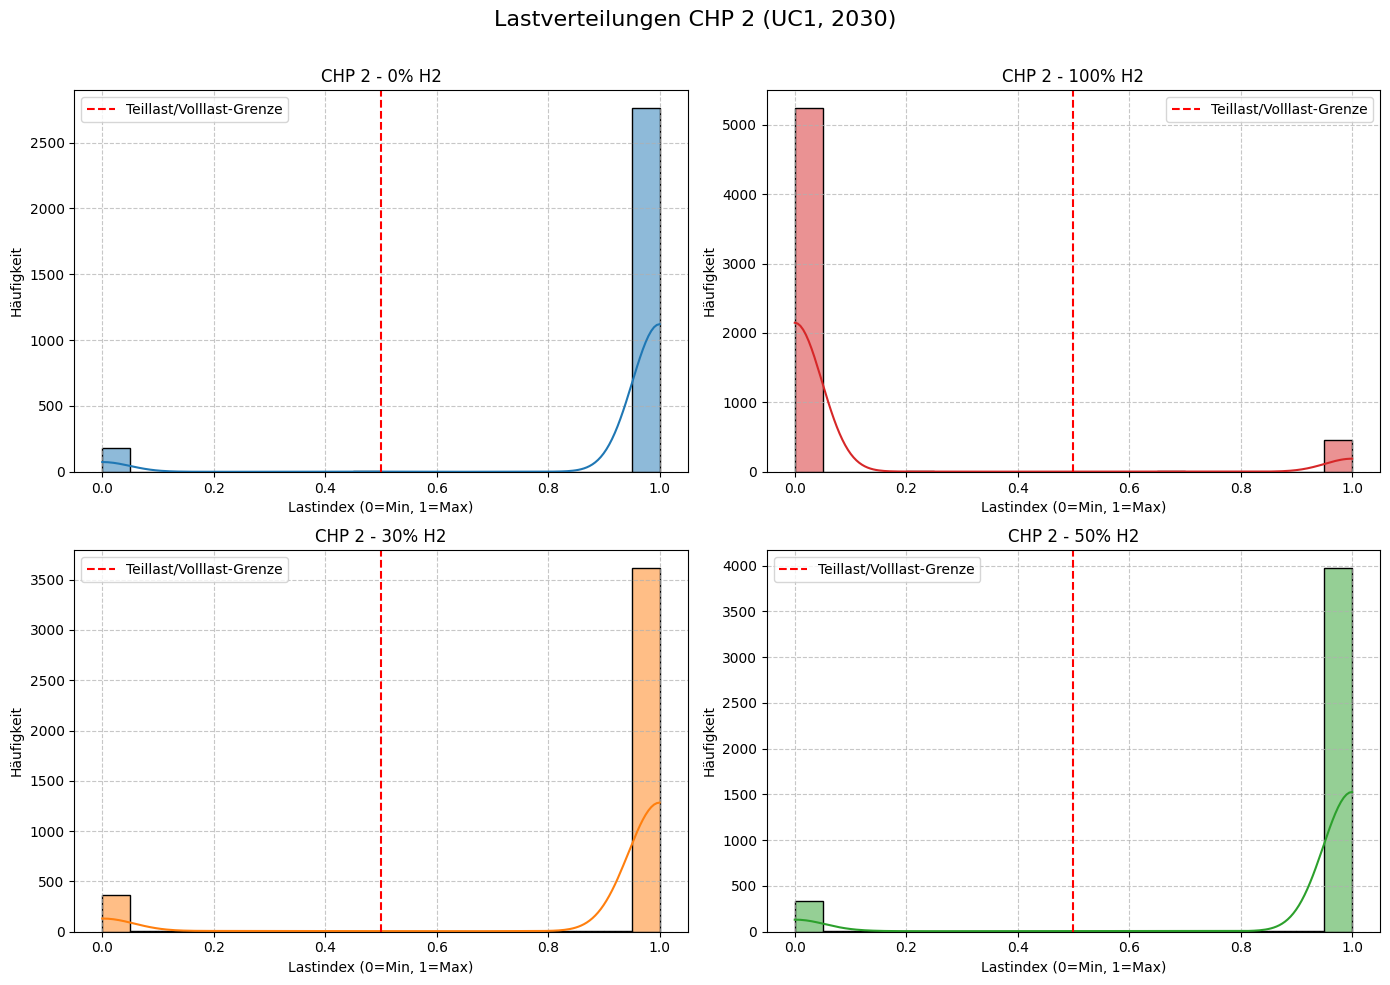

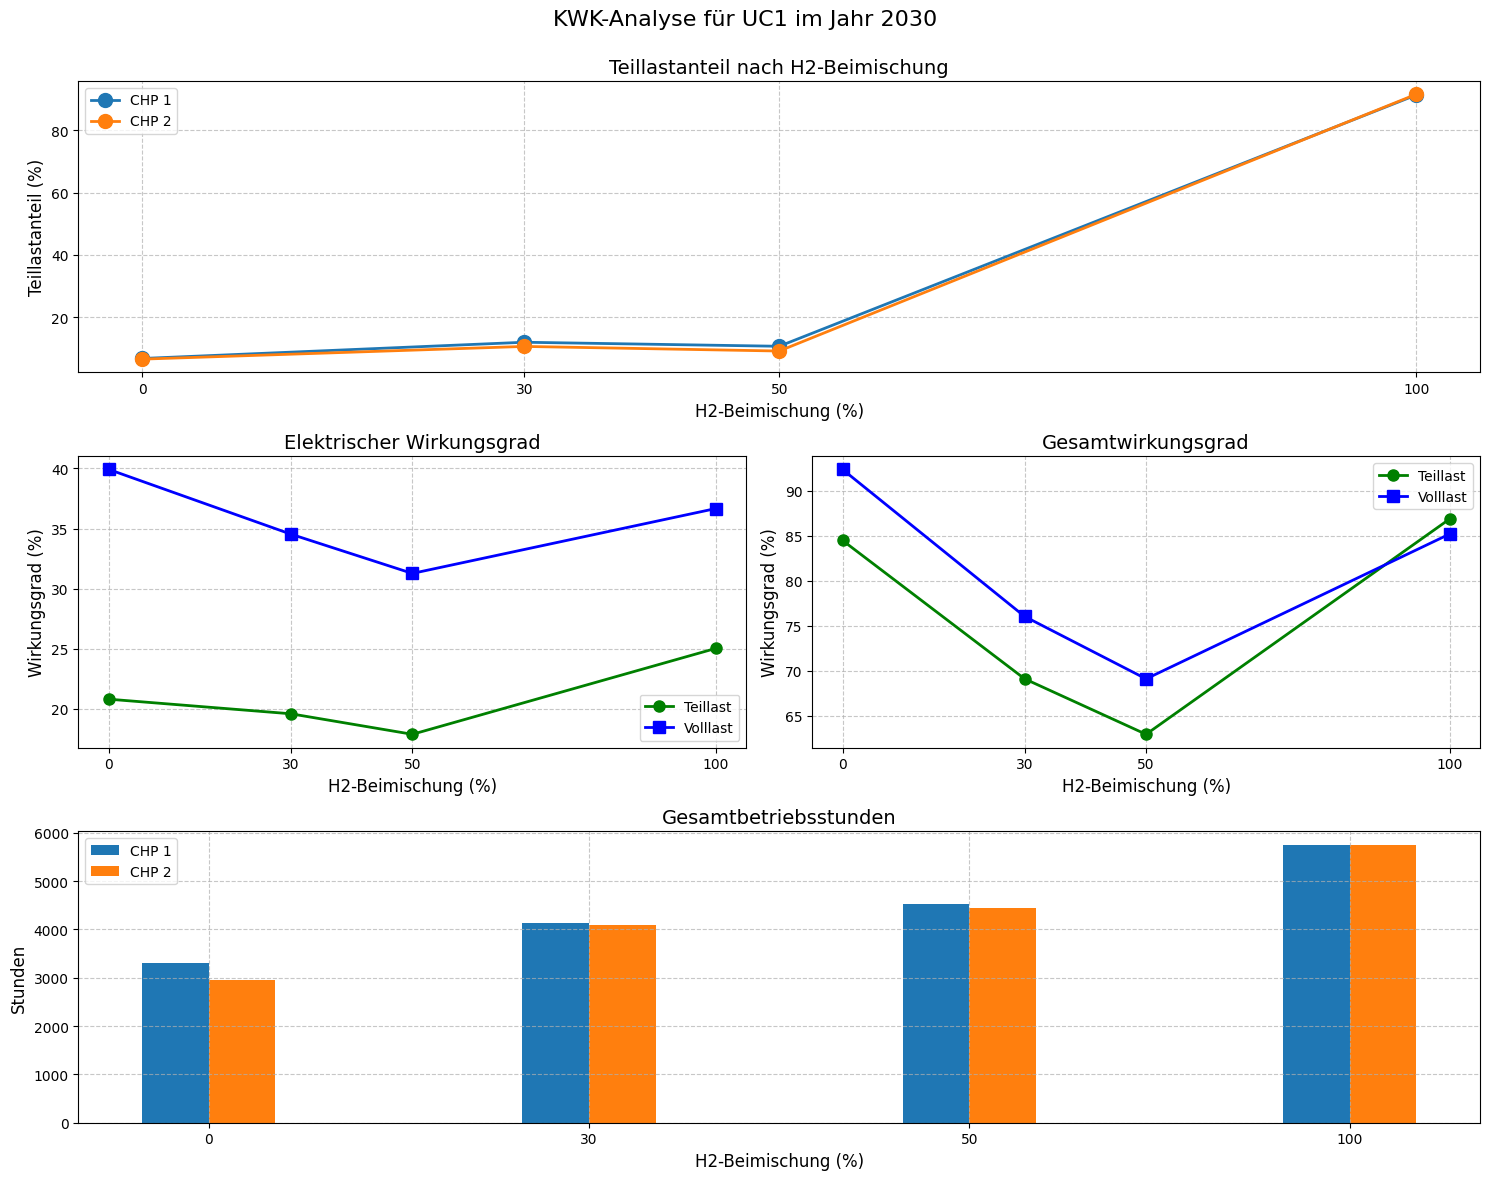

In [ ]:
def visualize_chp_analysis(results_df):
    """Erstellt Visualisierungen der CHP-Analyse-Ergebnisse."""
    if results_df.empty:
        print("Keine Daten für Visualisierung verfügbar.")
        return
    
    # 1. Teillastanteil nach H2-Beimischung
    plt.figure(figsize=(10, 6))
    for chp_unit in results_df['chp_unit'].unique():
        unit_data = results_df[results_df['chp_unit'] == chp_unit]
        unit_data = unit_data.sort_values('h2_admixture')
        
        plt.plot(unit_data['h2_admixture'], unit_data['part_load_percent'], 
                 marker='o', linewidth=2, markersize=10,
                 label=f'CHP {int(chp_unit)}', 
                 color=plt.cm.tab10(int(chp_unit)-1))
    
    plt.title(f'Teillastanteil nach H2-Beimischung ({USE_CASE.upper()}, {YEAR})', fontsize=14)
    plt.xlabel('H2-Beimischung (%)', fontsize=12)
    plt.ylabel('Teillastanteil (%)', fontsize=12)
    plt.xticks(results_df['h2_admixture'].unique())
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend()
    plt.tight_layout()
    plt.savefig(os.path.join(CHP_ANALYSIS_DIR, f'part_load_vs_h2_{USE_CASE}_{YEAR}.png'), dpi=300)
    plt.show()
    
    # 2. Elektrischer Wirkungsgrad bei Teil- und Volllast
    plt.figure(figsize=(12, 10))
    
    # Subplot für jede CHP-Einheit
    for i, chp_unit in enumerate(results_df['chp_unit'].unique()):
        plt.subplot(len(results_df['chp_unit'].unique()), 1, i+1)
        
        unit_data = results_df[results_df['chp_unit'] == chp_unit]
        unit_data = unit_data.sort_values('h2_admixture')
        
        x = unit_data['h2_admixture']
        
        plt.plot(x, unit_data['el_eff_part'], 'o-', color='green', linewidth=2, markersize=8, label='Teillast')
        plt.plot(x, unit_data['el_eff_full'], 's-', color='blue', linewidth=2, markersize=8, label='Volllast')
        
        # Verhältnis zwischen Teil- und Volllast plotten
        ratio = unit_data['el_eff_part'] / unit_data['el_eff_full']
        plt.plot(x, ratio * 20, '--', color='red', linewidth=1.5, label='Verhältnis (x20)')
        
        plt.title(f'Elektrischer Wirkungsgrad CHP {int(chp_unit)} ({USE_CASE.upper()}, {YEAR})', fontsize=14)
        plt.xlabel('H2-Beimischung (%)', fontsize=12)
        plt.ylabel('Wirkungsgrad (%)', fontsize=12)
        plt.xticks(unit_data['h2_admixture'].unique())
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.legend()
    
    plt.tight_layout()
    plt.savefig(os.path.join(CHP_ANALYSIS_DIR, f'efficiency_vs_h2_{USE_CASE}_{YEAR}.png'), dpi=300)
    plt.show()
    
    # 3. Betriebsstunden-Analyse
    plt.figure(figsize=(12, 6))
    
    for i, chp_unit in enumerate(results_df['chp_unit'].unique()):
        plt.subplot(1, len(results_df['chp_unit'].unique()), i+1)
        
        unit_data = results_df[results_df['chp_unit'] == chp_unit]
        unit_data = unit_data.sort_values('h2_admixture')
        
        admixtures = unit_data['h2_admixture']
        width = 0.35
        
        plt.bar(admixtures - width/2, unit_data['part_load_hours'], width, label='Teillast', color='lightblue')
        plt.bar(admixtures + width/2, unit_data['full_load_hours'], width, label='Volllast', color='navy')
        
        for j, admixture in enumerate(admixtures):
            plt.text(admixture - width/2, unit_data['part_load_hours'].iloc[j] + 100, 
                     f"{unit_data['part_load_percent'].iloc[j]:.1f}%", 
                     ha='center', va='bottom', fontsize=8)
            plt.text(admixture + width/2, unit_data['full_load_hours'].iloc[j] + 100, 
                     f"{unit_data['full_load_percent'].iloc[j]:.1f}%", 
                     ha='center', va='bottom', fontsize=8)
        
        plt.title(f'Betriebsstunden CHP {int(chp_unit)} ({USE_CASE.upper()}, {YEAR})', fontsize=14)
        plt.xlabel('H2-Beimischung (%)', fontsize=12)
        plt.ylabel('Stunden', fontsize=12)
        plt.xticks(admixtures)
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.legend()
    
    plt.tight_layout()
    plt.savefig(os.path.join(CHP_ANALYSIS_DIR, f'operating_hours_{USE_CASE}_{YEAR}.png'), dpi=300)
    plt.show()
    
    # 4. Lastverteilungen (Histogramme)
    for chp_unit in results_df['chp_unit'].unique():
        unit_data = results_df[results_df['chp_unit'] == chp_unit]
        
        if len(unit_data) > 1:  # Nur wenn mehrere Beimischungen vorhanden sind
            plt.figure(figsize=(14, 10))
            
            for i, row in enumerate(unit_data.itertuples()):
                if hasattr(row, 'load_distribution') and row.load_distribution:
                    plt.subplot(2, 2, i+1)
                    
                    # Histogramm der Lastverteilung
                    sns.histplot(row.load_distribution, bins=20, kde=True, 
                                 color=ADMIXTURE_COLORS.get(row.h2_admixture, 'gray'))
                    
                    plt.axvline(x=0.5, color='red', linestyle='--', 
                                label='Teillast/Volllast-Grenze')
                    
                    plt.title(f'CHP {int(chp_unit)} - {row.h2_admixture}% H2', fontsize=12)
                    plt.xlabel('Lastindex (0=Min, 1=Max)', fontsize=10)
                    plt.ylabel('Häufigkeit', fontsize=10)
                    plt.grid(True, linestyle='--', alpha=0.7)
                    plt.legend()
            
            plt.suptitle(f'Lastverteilungen CHP {int(chp_unit)} ({USE_CASE.upper()}, {YEAR})', 
                         fontsize=16, y=0.98)
            plt.tight_layout()
            plt.subplots_adjust(top=0.90)
            plt.savefig(os.path.join(CHP_ANALYSIS_DIR, f'load_distribution_chp{int(chp_unit)}_{USE_CASE}_{YEAR}.png'), dpi=300)
            plt.show()
    
    # 5. Zusammenfassende Darstellung für Präsentation
    plt.figure(figsize=(15, 12))
    gs = GridSpec(3, 2, figure=plt.gcf())
    
    # 5.1. Teillastanteil
    ax1 = plt.subplot(gs[0, :])
    for chp_unit in results_df['chp_unit'].unique():
        unit_data = results_df[results_df['chp_unit'] == chp_unit]
        unit_data = unit_data.sort_values('h2_admixture')
        
        ax1.plot(unit_data['h2_admixture'], unit_data['part_load_percent'], 
                marker='o', linewidth=2, markersize=10, 
                label=f'CHP {int(chp_unit)}',
                color=plt.cm.tab10(int(chp_unit)-1))
    
    ax1.set_title('Teillastanteil nach H2-Beimischung', fontsize=14)
    ax1.set_xlabel('H2-Beimischung (%)', fontsize=12)
    ax1.set_ylabel('Teillastanteil (%)', fontsize=12)
    ax1.set_xticks(results_df['h2_admixture'].unique())
    ax1.grid(True, linestyle='--', alpha=0.7)
    ax1.legend()
    
    # 5.2. Elektrischer Wirkungsgrad
    ax2 = plt.subplot(gs[1, 0])
    for chp_unit in results_df['chp_unit'].unique():
        unit_data = results_df[results_df['chp_unit'] == chp_unit]
        unit_data = unit_data.sort_values('h2_admixture')
        
        if chp_unit == results_df['chp_unit'].unique()[0]:  # Nur für ersten CHP
            ax2.plot(unit_data['h2_admixture'], unit_data['el_eff_part'], 
                    'o-', color='green', linewidth=2, markersize=8, label='Teillast')
            ax2.plot(unit_data['h2_admixture'], unit_data['el_eff_full'], 
                    's-', color='blue', linewidth=2, markersize=8, label='Volllast')
    
    ax2.set_title('Elektrischer Wirkungsgrad', fontsize=14)
    ax2.set_xlabel('H2-Beimischung (%)', fontsize=12)
    ax2.set_ylabel('Wirkungsgrad (%)', fontsize=12)
    ax2.set_xticks(results_df['h2_admixture'].unique())
    ax2.grid(True, linestyle='--', alpha=0.7)
    ax2.legend()
    
    # 5.3. Gesamtwirkungsgrad
    ax3 = plt.subplot(gs[1, 1])
    for chp_unit in results_df['chp_unit'].unique():
        unit_data = results_df[results_df['chp_unit'] == chp_unit]
        unit_data = unit_data.sort_values('h2_admixture')
        
        if chp_unit == results_df['chp_unit'].unique()[0]:  # Nur für ersten CHP
            ax3.plot(unit_data['h2_admixture'], unit_data['total_eff_part'], 
                    'o-', color='green', linewidth=2, markersize=8, label='Teillast')
            ax3.plot(unit_data['h2_admixture'], unit_data['total_eff_full'], 
                    's-', color='blue', linewidth=2, markersize=8, label='Volllast')
    
    ax3.set_title('Gesamtwirkungsgrad', fontsize=14)
    ax3.set_xlabel('H2-Beimischung (%)', fontsize=12)
    ax3.set_ylabel('Wirkungsgrad (%)', fontsize=12)
    ax3.set_xticks(results_df['h2_admixture'].unique())
    ax3.grid(True, linestyle='--', alpha=0.7)
    ax3.legend()
    
    # 5.4. Vergleich der Betriebsstunden
    ax4 = plt.subplot(gs[2, :])
    
    n_admixtures = len(results_df['h2_admixture'].unique())
    n_units = len(results_df['chp_unit'].unique())
    width = 0.35 / n_units
    
    for i, chp_unit in enumerate(sorted(results_df['chp_unit'].unique())):
        unit_data = results_df[results_df['chp_unit'] == chp_unit]
        unit_data = unit_data.sort_values('h2_admixture')
        
        positions = np.arange(len(unit_data))
        offset = (i - n_units/2 + 0.5) * width
        
        ax4.bar(positions + offset, unit_data['operating_hours'], width, 
                label=f'CHP {int(chp_unit)}', color=plt.cm.tab10(int(chp_unit)-1))
    
    ax4.set_title('Gesamtbetriebsstunden', fontsize=14)
    ax4.set_xlabel('H2-Beimischung (%)', fontsize=12)
    ax4.set_ylabel('Stunden', fontsize=12)
    ax4.set_xticks(np.arange(n_admixtures))
    ax4.set_xticklabels(sorted(results_df['h2_admixture'].unique()))
    ax4.grid(True, linestyle='--', alpha=0.7)
    ax4.legend()
    
    plt.suptitle(f'KWK-Analyse für {USE_CASE.upper()} im Jahr {YEAR}', fontsize=16, y=0.98)
    plt.tight_layout()
    plt.subplots_adjust(top=0.92)
    plt.savefig(os.path.join(CHP_ANALYSIS_DIR, f'summary_{USE_CASE}_{YEAR}.png'), dpi=300)
    plt.show()

# Visualisierungen erstellen
if 'results_df' in locals() and not results_df.empty:
    visualize_chp_analysis(results_df)

In [ ]:
def analyze_chp_heat_production(collection, chp_units=ANALYZE_CHP_UNITS, h2_admixtures=H2_ADMIXTURES):
    """Analysiert die Wärmeerzeugung der CHP-Anlagen bei verschiedenen H2-Beimischungen."""
    heat_data = []
    
    for scenario_name, scenario in collection.scenarios.items():
        if not scenario_name.startswith(f"{USE_CASE}_{YEAR}_"):
            continue
            
        # H2-Beimischung aus dem Namen extrahieren
        h2_match = re.search(r'_(\d+)h2', scenario_name)
        if not h2_match:
            print(f"Warnung: Konnte H2-Beimischung nicht aus dem Namen '{scenario_name}' extrahieren")
            continue
            
        h2_admixture = int(h2_match.group(1))
        if h2_admixture not in h2_admixtures:
            continue
            
        print(f"\nAnalysiere Wärmeerzeugung für {scenario_name} (H2-Beimischung: {h2_admixture}%)")
        
        df = scenario.processed_output
        
        # Für jede CHP-Einheit die Wärmeerzeugungsdaten sammeln
        for chp_unit in chp_units:
            bin_col = f"chp_{chp_unit}.bin"
            heat_col = f"chp_{chp_unit}.heat"
            power_col = f"chp_{chp_unit}.power"
            
            # Prüfen, ob die notwendigen Spalten existieren
            if not all(col in df.columns for col in [bin_col, heat_col]):
                print(f"Warnung: Notwendige Spalten für CHP {chp_unit} fehlen")
                continue
                
            # Betriebsdaten filtern (nur wenn die Anlage läuft)
            operating_data = df[df[bin_col] > 0.5]
            
            if len(operating_data) == 0:
                print(f"Warnung: Keine Betriebsdaten für CHP {chp_unit} gefunden")
                continue
                
            # Wärmeerzeugung analysieren
            total_heat = operating_data[heat_col].sum()
            avg_heat = operating_data[heat_col].mean()
            max_heat = operating_data[heat_col].max()
            min_heat = operating_data[heat_col].min()
            operating_hours = len(operating_data)
            
            # Strom-zu-Wärme-Verhältnis
            if power_col in operating_data.columns:
                power_to_heat_ratio = operating_data[power_col].sum() / total_heat if total_heat > 0 else 0
            else:
                power_to_heat_ratio = None
                
            # Tägliche und saisonale Auswertung
            if 'datetime' in operating_data.columns:
                # Gruppieren nach Monat für saisonale Analyse
                operating_data['month'] = operating_data['datetime'].dt.month
                monthly_heat = operating_data.groupby('month')[heat_col].sum()
                
                # Winter (Dez-Feb), Frühling (Mär-Mai), Sommer (Jun-Aug), Herbst (Sep-Nov)
                winter_heat = monthly_heat.get(12, 0) + monthly_heat.get(1, 0) + monthly_heat.get(2, 0)
                spring_heat = monthly_heat.get(3, 0) + monthly_heat.get(4, 0) + monthly_heat.get(5, 0)
                summer_heat = monthly_heat.get(6, 0) + monthly_heat.get(7, 0) + monthly_heat.get(8, 0)
                autumn_heat = monthly_heat.get(9, 0) + monthly_heat.get(10, 0) + monthly_heat.get(11, 0)
                
                # Stündliche Analyse für tageszeitliche Muster
                operating_data['hour'] = operating_data['datetime'].dt.hour
                hourly_heat = operating_data.groupby('hour')[heat_col].mean()
                
                # Tag (8-20 Uhr) vs. Nacht (20-8 Uhr)
                day_hours = [h for h in range(8, 20)]
                night_hours = [h for h in range(0, 8)] + [h for h in range(20, 24)]
                
                day_heat = operating_data[operating_data['hour'].isin(day_hours)][heat_col].sum()
                night_heat = operating_data[operating_data['hour'].isin(night_hours)][heat_col].sum()
                
                day_night_ratio = day_heat / night_heat if night_heat > 0 else float('inf')
            else:
                winter_heat = spring_heat = summer_heat = autumn_heat = None
                hourly_heat = None
                day_heat = night_heat = day_night_ratio = None
            
            # Ergebnisse speichern
            heat_result = {
                'scenario': scenario_name,
                'chp_unit': chp_unit,
                'h2_admixture': h2_admixture,
                'total_heat': total_heat,
                'avg_heat': avg_heat,
                'max_heat': max_heat,
                'min_heat': min_heat,
                'operating_hours': operating_hours,
                'power_to_heat_ratio': power_to_heat_ratio,
                'winter_heat': winter_heat,
                'spring_heat': spring_heat,
                'summer_heat': summer_heat,
                'autumn_heat': autumn_heat,
                'day_heat': day_heat,
                'night_heat': night_heat,
                'day_night_ratio': day_night_ratio,
                'hourly_heat': hourly_heat.to_dict() if hasattr(hourly_heat, 'to_dict') else None,
                'time_series': operating_data[['datetime', heat_col]].set_index('datetime').to_dict()[heat_col] if 'datetime' in operating_data.columns else None
            }
            
            heat_data.append(heat_result)
    
    return heat_data

def visualize_chp_heat_production(heat_results_df):
    """Visualisiert die Wärmeerzeugung der CHP-Anlagen."""
    if heat_results_df.empty:
        print("Keine Daten für die Wärmeerzeugungsanalyse verfügbar.")
        return
    
    # 1. Gesamtwärmeerzeugung nach H2-Beimischung
    plt.figure(figsize=(12, 6))
    for chp_unit in heat_results_df['chp_unit'].unique():
        unit_data = heat_results_df[heat_results_df['chp_unit'] == chp_unit]
        unit_data = unit_data.sort_values('h2_admixture')
        
        plt.plot(unit_data['h2_admixture'], unit_data['total_heat'], 
                 marker='o', linewidth=2, markersize=10,
                 label=f'CHP {int(chp_unit)}',
                 color=plt.cm.tab10(int(chp_unit)-1))
    
    plt.title(f'Gesamtwärmeerzeugung nach H2-Beimischung ({USE_CASE.upper()}, {YEAR})', fontsize=14)
    plt.xlabel('H2-Beimischung (%)', fontsize=12)
    plt.ylabel('Wärmeerzeugung (MWh)', fontsize=12)
    plt.xticks(heat_results_df['h2_admixture'].unique())
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend()
    plt.tight_layout()
    plt.savefig(os.path.join(CHP_ANALYSIS_DIR, f'total_heat_vs_h2_{USE_CASE}_{YEAR}.png'), dpi=300)
    plt.show()
    
    # 2. Durchschnittliche Wärmeerzeugung pro Betriebsstunde
    plt.figure(figsize=(12, 6))
    for chp_unit in heat_results_df['chp_unit'].unique():
        unit_data = heat_results_df[heat_results_df['chp_unit'] == chp_unit]
        unit_data = unit_data.sort_values('h2_admixture')
        
        plt.plot(unit_data['h2_admixture'], unit_data['avg_heat'], 
                 marker='o', linewidth=2, markersize=10,
                 label=f'CHP {int(chp_unit)}',
                 color=plt.cm.tab10(int(chp_unit)-1))
    
    plt.title(f'Durchschnittliche Wärmeerzeugung nach H2-Beimischung ({USE_CASE.upper()}, {YEAR})', fontsize=14)
    plt.xlabel('H2-Beimischung (%)', fontsize=12)
    plt.ylabel('Durchschnittliche Wärmeleistung (MW)', fontsize=12)
    plt.xticks(heat_results_df['h2_admixture'].unique())
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend()
    plt.tight_layout()
    plt.savefig(os.path.join(CHP_ANALYSIS_DIR, f'avg_heat_vs_h2_{USE_CASE}_{YEAR}.png'), dpi=300)
    plt.show()
    
    # 3. Strom-zu-Wärme-Verhältnis
    if 'power_to_heat_ratio' in heat_results_df.columns:
        plt.figure(figsize=(12, 6))
        for chp_unit in heat_results_df['chp_unit'].unique():
            unit_data = heat_results_df[heat_results_df['chp_unit'] == chp_unit]
            unit_data = unit_data.sort_values('h2_admixture')
            
            if unit_data['power_to_heat_ratio'].notna().any():
                plt.plot(unit_data['h2_admixture'], unit_data['power_to_heat_ratio'], 
                         marker='o', linewidth=2, markersize=10,
                         label=f'CHP {int(chp_unit)}',
                         color=plt.cm.tab10(int(chp_unit)-1))
        
        plt.title(f'Strom-zu-Wärme-Verhältnis nach H2-Beimischung ({USE_CASE.upper()}, {YEAR})', fontsize=14)
        plt.xlabel('H2-Beimischung (%)', fontsize=12)
        plt.ylabel('Strom/Wärme-Verhältnis', fontsize=12)
        plt.xticks(heat_results_df['h2_admixture'].unique())
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.legend()
        plt.tight_layout()
        plt.savefig(os.path.join(CHP_ANALYSIS_DIR, f'power_to_heat_ratio_{USE_CASE}_{YEAR}.png'), dpi=300)
        plt.show()
    
    # 4. Saisonale Wärmeerzeugung
    if all(col in heat_results_df.columns for col in ['winter_heat', 'spring_heat', 'summer_heat', 'autumn_heat']):
        for chp_unit in heat_results_df['chp_unit'].unique():
            unit_data = heat_results_df[heat_results_df['chp_unit'] == chp_unit]
            unit_data = unit_data.sort_values('h2_admixture')
            
            if not unit_data[['winter_heat', 'spring_heat', 'summer_heat', 'autumn_heat']].isna().all().all():
                plt.figure(figsize=(14, 8))
                
                x = np.arange(len(unit_data))
                width = 0.2
                
                seasons = ['Winter', 'Frühling', 'Sommer', 'Herbst']
                colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
                
                for i, (season, col) in enumerate(zip(seasons, ['winter_heat', 'spring_heat', 'summer_heat', 'autumn_heat'])):
                    if not unit_data[col].isna().all():
                        plt.bar(x + (i-1.5)*width, unit_data[col], width, label=season, color=colors[i])
                
                plt.title(f'Saisonale Wärmeerzeugung CHP {int(chp_unit)} ({USE_CASE.upper()}, {YEAR})', fontsize=14)
                plt.xlabel('H2-Beimischung (%)', fontsize=12)
                plt.ylabel('Wärmeerzeugung (MWh)', fontsize=12)
                plt.xticks(x, unit_data['h2_admixture'])
                plt.grid(axis='y', linestyle='--', alpha=0.7)
                plt.legend()
                plt.tight_layout()
                plt.savefig(os.path.join(CHP_ANALYSIS_DIR, f'seasonal_heat_chp{int(chp_unit)}_{USE_CASE}_{YEAR}.png'), dpi=300)
                plt.show()
    
    # 5. Tag-Nacht-Vergleich (gestapelter Balkenplot)
    if all(col in heat_results_df.columns for col in ['day_heat', 'night_heat']):
        plt.figure(figsize=(14, 8))
        
        prev_day = np.zeros(len(heat_results_df['h2_admixture'].unique()))
        prev_night = np.zeros(len(heat_results_df['h2_admixture'].unique()))
        
        for i, chp_unit in enumerate(sorted(heat_results_df['chp_unit'].unique())):
            unit_data = heat_results_df[heat_results_df['chp_unit'] == chp_unit]
            unit_data = unit_data.sort_values('h2_admixture')
            
            if not unit_data[['day_heat', 'night_heat']].isna().all().all():
                x = np.arange(len(unit_data))
                
                day_data = unit_data['day_heat'].to_numpy()
                night_data = unit_data['night_heat'].to_numpy()
                
                # Tag-Balken
                bars1 = plt.bar(x, day_data, 0.35, 
                               label=f'CHP {int(chp_unit)} - Tag' if i == 0 else f'CHP {int(chp_unit)} - Tag',
                               bottom=prev_day,
                               color=plt.cm.tab10(i*2), alpha=0.7)
                
                # Nacht-Balken
                bars2 = plt.bar(x+0.35, night_data, 0.35, 
                               label=f'CHP {int(chp_unit)} - Nacht' if i == 0 else f'CHP {int(chp_unit)} - Nacht',
                               bottom=prev_night,
                               color=plt.cm.tab10(i*2+1), alpha=0.7)
                
                # Summieren für den nächsten Stapel
                prev_day += day_data
                prev_night += night_data
        
        plt.title(f'Tag-Nacht-Wärmeerzeugung nach H2-Beimischung ({USE_CASE.upper()}, {YEAR})', fontsize=14)
        plt.xlabel('H2-Beimischung (%)', fontsize=12)
        plt.ylabel('Wärmeerzeugung (MWh)', fontsize=12)
        plt.xticks(x + 0.175, sorted(heat_results_df['h2_admixture'].unique()))
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.legend()
        plt.tight_layout()
        plt.savefig(os.path.join(CHP_ANALYSIS_DIR, f'day_night_heat_{USE_CASE}_{YEAR}.png'), dpi=300)
        plt.show()
    
    # 6. Durchschnittlicher stündlicher Wärmeerzeugungsverlauf (24h)
    hourly_data_available = False
    for _, row in heat_results_df.iterrows():
        if isinstance(row.get('hourly_heat'), dict) and row['hourly_heat']:
            hourly_data_available = True
            break
    
    if hourly_data_available:
        plt.figure(figsize=(14, 8))
        
        for idx, row in heat_results_df.iterrows():
            if isinstance(row.get('hourly_heat'), dict) and row['hourly_heat']:
                # Konvertiere dict in sortierte Liste nach Stunde
                hourly_values = [row['hourly_heat'].get(hour, 0) for hour in range(24)]
                
                plt.plot(range(24), hourly_values, 
                         label=f"CHP {int(row['chp_unit'])} - {row['h2_admixture']}% H2",
                         color=ADMIXTURE_COLORS.get(row['h2_admixture'], 'gray'),
                         linestyle='-' if row['chp_unit'] == 1 else '--',
                         linewidth=2)
        
        plt.title(f'Durchschnittliche stündliche Wärmeerzeugung ({USE_CASE.upper()}, {YEAR})', fontsize=14)
        plt.xlabel('Stunde des Tages', fontsize=12)
        plt.ylabel('Durchschnittliche Wärmeleistung (MW)', fontsize=12)
        plt.xticks(range(0, 24, 2))
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.legend()
        plt.tight_layout()
        plt.savefig(os.path.join(CHP_ANALYSIS_DIR, f'hourly_heat_profile_{USE_CASE}_{YEAR}.png'), dpi=300)
        plt.show()
    
    # 7. Zusammenfassende Übersicht (für Präsentationen)
    plt.figure(figsize=(15, 12))
    gs = GridSpec(3, 2, figure=plt.gcf())
    
    # 7.1 Gesamtwärmeerzeugung
    ax1 = plt.subplot(gs[0, 0])
    for chp_unit in heat_results_df['chp_unit'].unique():
        unit_data = heat_results_df[heat_results_df['chp_unit'] == chp_unit]
        unit_data = unit_data.sort_values('h2_admixture')
        
        ax1.plot(unit_data['h2_admixture'], unit_data['total_heat'], 
                marker='o', linewidth=2, markersize=8,
                label=f'CHP {int(chp_unit)}',
                color=plt.cm.tab10(int(chp_unit)-1))
    
    ax1.set_title('Gesamtwärmeerzeugung', fontsize=14)
    ax1.set_xlabel('H2-Beimischung (%)', fontsize=12)
    ax1.set_ylabel('Wärmeerzeugung (MWh)', fontsize=12)
    ax1.set_xticks(heat_results_df['h2_admixture'].unique())
    ax1.grid(True, linestyle='--', alpha=0.7)
    ax1.legend()
    
    # 7.2 Durchschnittliche Wärmeleistung
    ax2 = plt.subplot(gs[0, 1])
    for chp_unit in heat_results_df['chp_unit'].unique():
        unit_data = heat_results_df[heat_results_df['chp_unit'] == chp_unit]
        unit_data = unit_data.sort_values('h2_admixture')
        
        ax2.plot(unit_data['h2_admixture'], unit_data['avg_heat'], 
                marker='o', linewidth=2, markersize=8,
                label=f'CHP {int(chp_unit)}',
                color=plt.cm.tab10(int(chp_unit)-1))
    
    ax2.set_title('Durchschnittliche Wärmeleistung', fontsize=14)
    ax2.set_xlabel('H2-Beimischung (%)', fontsize=12)
    ax2.set_ylabel('Wärmeleistung (MW)', fontsize=12)
    ax2.set_xticks(heat_results_df['h2_admixture'].unique())
    ax2.grid(True, linestyle='--', alpha=0.7)
    ax2.legend()
    
    # 7.3 Strom-zu-Wärme-Verhältnis
    ax3 = plt.subplot(gs[1, 0])
    for chp_unit in heat_results_df['chp_unit'].unique():
        unit_data = heat_results_df[heat_results_df['chp_unit'] == chp_unit]
        unit_data = unit_data.sort_values('h2_admixture')
        
        if 'power_to_heat_ratio' in unit_data.columns and unit_data['power_to_heat_ratio'].notna().any():
            ax3.plot(unit_data['h2_admixture'], unit_data['power_to_heat_ratio'], 
                    marker='o', linewidth=2, markersize=8,
                    label=f'CHP {int(chp_unit)}',
                    color=plt.cm.tab10(int(chp_unit)-1))
    
    ax3.set_title('Strom-zu-Wärme-Verhältnis', fontsize=14)
    ax3.set_xlabel('H2-Beimischung (%)', fontsize=12)
    ax3.set_ylabel('Strom/Wärme', fontsize=12)
    ax3.set_xticks(heat_results_df['h2_admixture'].unique())
    ax3.grid(True, linestyle='--', alpha=0.7)
    ax3.legend()
    
    # 7.4 Betriebsstunden
    ax4 = plt.subplot(gs[1, 1])
    for chp_unit in heat_results_df['chp_unit'].unique():
        unit_data = heat_results_df[heat_results_df['chp_unit'] == chp_unit]
        unit_data = unit_data.sort_values('h2_admixture')
        
        ax4.plot(unit_data['h2_admixture'], unit_data['operating_hours'], 
                marker='o', linewidth=2, markersize=8,
                label=f'CHP {int(chp_unit)}',
                color=plt.cm.tab10(int(chp_unit)-1))
    
    ax4.set_title('Betriebsstunden', fontsize=14)
    ax4.set_xlabel('H2-Beimischung (%)', fontsize=12)
    ax4.set_ylabel('Stunden', fontsize=12)
    ax4.set_xticks(heat_results_df['h2_admixture'].unique())
    ax4.grid(True, linestyle='--', alpha=0.7)
    ax4.legend()
    
    # 7.5 Saisonale Aufteilung (Beispiel für CHP 1)
    ax5 = plt.subplot(gs[2, :])
    if 1 in heat_results_df['chp_unit'].unique() and all(col in heat_results_df.columns for col in ['winter_heat', 'spring_heat', 'summer_heat', 'autumn_heat']):
        chp1_data = heat_results_df[heat_results_df['chp_unit'] == 1].sort_values('h2_admixture')
        
        if not chp1_data[['winter_heat', 'spring_heat', 'summer_heat', 'autumn_heat']].isna().all().all():
            x = np.arange(len(chp1_data))
            width = 0.2
            
            seasons = ['Winter', 'Frühling', 'Sommer', 'Herbst']
            colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
            
            for i, (season, col) in enumerate(zip(seasons, ['winter_heat', 'spring_heat', 'summer_heat', 'autumn_heat'])):
                if not chp1_data[col].isna().all():
                    # Normalisierte Daten zeigen (Prozentanteil)
                    total_seasonal = chp1_data['winter_heat'] + chp1_data['spring_heat'] + chp1_data['summer_heat'] + chp1_data['autumn_heat']
                    normalized_data = chp1_data[col] / total_seasonal * 100
                    
                    ax5.bar(x + (i-1.5)*width, normalized_data, width, label=season, color=colors[i])
            
            ax5.set_title('Saisonale Verteilung der Wärmeerzeugung (CHP 1)', fontsize=14)
            ax5.set_xlabel('H2-Beimischung (%)', fontsize=12)
            ax5.set_ylabel('Anteil (%)', fontsize=12)
            ax5.set_xticks(x)
            ax5.set_xticklabels(chp1_data['h2_admixture'])
            ax5.grid(axis='y', linestyle='--', alpha=0.7)
            ax5.legend()
    
    plt.suptitle(f'Wärmeerzeugungsanalyse für {USE_CASE.upper()} im Jahr {YEAR}', fontsize=16, y=0.98)
    plt.tight_layout()
    plt.subplots_adjust(top=0.92)
    plt.savefig(os.path.join(CHP_ANALYSIS_DIR, f'heat_summary_{USE_CASE}_{YEAR}.png'), dpi=300)
    plt.show()

def summarize_heat_findings(heat_results_df):
    """Erstellt eine textuelle Zusammenfassung der Wärmeerzeugungsanalyse."""
    if heat_results_df.empty:
        print("Keine Daten für die Wärmeerzeugungszusammenfassung verfügbar.")
        return
    
    print("\n==== ZUSAMMENFASSUNG DER WÄRMEERZEUGUNGSANALYSE ====")
    print(f"Use Case: {USE_CASE.upper()}, Jahr: {YEAR}")
    print(f"Analysierte H2-Beimischungen: {sorted(heat_results_df['h2_admixture'].unique())}")
    print(f"Analysierte CHP-Einheiten: {sorted(heat_results_df['chp_unit'].unique())}")
    
    # Gesamtwärmeerzeugung
    print("\n1. GESAMTWÄRMEERZEUGUNG")
    for chp_unit in sorted(heat_results_df['chp_unit'].unique()):
        print(f"\nCHP {int(chp_unit)}:")
        unit_data = heat_results_df[heat_results_df['chp_unit'] == chp_unit].sort_values('h2_admixture')
        
        for _, row in unit_data.iterrows():
            print(f"  {row['h2_admixture']}% H2: {row['total_heat']:.1f} MWh, "
                  f"Ø {row['avg_heat']:.2f} MW während {row['operating_hours']} Betriebsstunden")
    
    # Vergleich der Wärmeerzeugung bei verschiedenen H2-Beimischungen
    print("\n2. RELATIVER VERGLEICH")
    if 0 in heat_results_df['h2_admixture'].values:
        for chp_unit in sorted(heat_results_df['chp_unit'].unique()):
            print(f"\nCHP {int(chp_unit)}:")
            unit_data = heat_results_df[heat_results_df['chp_unit'] == chp_unit].sort_values('h2_admixture')
            
            base_heat = unit_data[unit_data['h2_admixture'] == 0]['total_heat'].values
            if len(base_heat) > 0:
                base_heat = base_heat[0]
                for _, row in unit_data.iterrows():
                    if row['h2_admixture'] > 0:  # Vergleiche nur Beimischungen > 0%
                        rel_change = (row['total_heat'] - base_heat) / base_heat * 100 if base_heat > 0 else float('inf')
                        print(f"  {row['h2_admixture']}% H2: {rel_change:+.1f}% Wärmeerzeugung im Vergleich zu 0% H2")
    
    # Strom-zu-Wärme-Verhältnis
    if 'power_to_heat_ratio' in heat_results_df.columns:
        print("\n3. STROM-ZU-WÄRME-VERHÄLTNIS")
        for chp_unit in sorted(heat_results_df['chp_unit'].unique()):
            print(f"\nCHP {int(chp_unit)}:")
            unit_data = heat_results_df[heat_results_df['chp_unit'] == chp_unit].sort_values('h2_admixture')
            
            for _, row in unit_data.iterrows():
                if pd.notna(row.get('power_to_heat_ratio')):
                    print(f"  {row['h2_admixture']}% H2: {row['power_to_heat_ratio']:.3f} (Strom/Wärme)")
    
    # Saisonale Analyse
    seasonal_cols = ['winter_heat', 'spring_heat', 'summer_heat', 'autumn_heat']
    if all(col in heat_results_df.columns for col in seasonal_cols):
        print("\n4. SAISONALE VERTEILUNG")
        for chp_unit in sorted(heat_results_df['chp_unit'].unique()):
            print(f"\nCHP {int(chp_unit)}:")
            unit_data = heat_results_df[heat_results_df['chp_unit'] == chp_unit].sort_values('h2_admixture')
            
            for _, row in unit_data.iterrows():
                if all(pd.notna(row.get(col)) for col in seasonal_cols):
                    total = row['winter_heat'] + row['spring_heat'] + row['summer_heat'] + row['autumn_heat']
                    winter_pct = row['winter_heat'] / total * 100 if total > 0 else 0
                    spring_pct = row['spring_heat'] / total * 100 if total > 0 else 0
                    summer_pct = row['summer_heat'] / total * 100 if total > 0 else 0
                    autumn_pct = row['autumn_heat'] / total * 100 if total > 0 else 0
                    
                    print(f"  {row['h2_admixture']}% H2: Winter {winter_pct:.1f}%, "
                          f"Frühling {spring_pct:.1f}%, Sommer {summer_pct:.1f}%, Herbst {autumn_pct:.1f}%")
    
    # Tag-Nacht-Verhältnis
    if all(col in heat_results_df.columns for col in ['day_heat', 'night_heat']):
        print("\n5. TAG-NACHT-VERHÄLTNIS")
        for chp_unit in sorted(heat_results_df['chp_unit'].unique()):
            print(f"\nCHP {int(chp_unit)}:")
            unit_data = heat_results_df[heat_results_df['chp_unit'] == chp_unit].sort_values('h2_admixture')
            
            for _, row in unit_data.iterrows():
                if pd.notna(row.get('day_heat')) and pd.notna(row.get('night_heat')):
                    day_pct = row['day_heat'] / (row['day_heat'] + row['night_heat']) * 100 if (row['day_heat'] + row['night_heat']) > 0 else 0
                    night_pct = 100 - day_pct
                    
                    print(f"  {row['h2_admixture']}% H2: Tag {day_pct:.1f}%, Nacht {night_pct:.1f}%, "
                          f"Tag/Nacht-Verhältnis: {row.get('day_night_ratio', 0):.2f}")
    
    # Schlussfolgerungen
    print("\n6. SCHLUSSFOLGERUNGEN")
    
    # Prüfen, ob die Wärmeerzeugung bei höheren H2-Beimischungen steigt
    higher_heat_with_h2 = False
    if 0 in heat_results_df['h2_admixture'].values and 100 in heat_results_df['h2_admixture'].values:
        for chp_unit in sorted(heat_results_df['chp_unit'].unique()):
            h0_data = heat_results_df[(heat_results_df['chp_unit'] == chp_unit) & (heat_results_df['h2_admixture'] == 0)]
            h100_data = heat_results_df[(heat_results_df['chp_unit'] == chp_unit) & (heat_results_df['h2_admixture'] == 100)]
            
            if not h0_data.empty and not h100_data.empty:
                if h100_data.iloc[0]['total_heat'] > h0_data.iloc[0]['total_heat']:
                    higher_heat_with_h2 = True
                    break
    
    if higher_heat_with_h2:
        print("• Bei 100% H2-Beimischung wird insgesamt mehr Wärme erzeugt als bei 0% H2.")
        print("  Dies könnte auf längere Betriebszeiten oder bessere thermische Effizienz zurückzuführen sein.")
    else:
        print("• Es wurde kein eindeutiger Trend zu höherer Wärmeerzeugung bei 100% H2 festgestellt.")
    
    # Prüfen, ob sich die durchschnittliche Wärmeleistung ändert
    avg_heat_change = []
    if 0 in heat_results_df['h2_admixture'].values:
        for chp_unit in sorted(heat_results_df['chp_unit'].unique()):
            h0_data = heat_results_df[(heat_results_df['chp_unit'] == chp_unit) & (heat_results_df['h2_admixture'] == 0)]
            if not h0_data.empty:
                base_avg = h0_data.iloc[0]['avg_heat']
                if base_avg > 0:
                    for h2_level in [admix for admix in sorted(heat_results_df['h2_admixture'].unique()) if admix > 0]:
                        h_data = heat_results_df[(heat_results_df['chp_unit'] == chp_unit) & (heat_results_df['h2_admixture'] == h2_level)]
                        if not h_data.empty:
                            avg_change = (h_data.iloc[0]['avg_heat'] - base_avg) / base_avg * 100
                            avg_heat_change.append(avg_change)
    
    if avg_heat_change:
        avg_of_changes = sum(avg_heat_change) / len(avg_heat_change)
        if abs(avg_of_changes) > 5:  # Schwellenwert für signifikante Änderung
            if avg_of_changes > 0:
                print(f"• Die durchschnittliche Wärmeleistung steigt bei höheren H2-Beimischungen um ca. {avg_of_changes:.1f}%.")
            else:
                print(f"• Die durchschnittliche Wärmeleistung sinkt bei höheren H2-Beimischungen um ca. {abs(avg_of_changes):.1f}%.")
        else:
            print("• Die durchschnittliche Wärmeleistung bleibt bei verschiedenen H2-Beimischungen relativ konstant.")
    
    print("\n• Die Wärmeerzeugung wird beeinflusst durch:")
    print("  - Die spezifischen Wärme-Charakteristiken der CHP-Anlagen bei verschiedenen H2-Beimischungen")
    print("  - Die Betriebsstrategien und -zeiten, die durch wirtschaftliche Faktoren bestimmt werden")
    print("  - Den Wärmebedarf und die Anforderungen des Wärmenetzes")
    print("==== ENDE DER WÄRMEERZEUGUNGSANALYSE ====")

Szenario gefunden: uc1_2030_0h2
Szenario gefunden: uc1_2030_30h2
Szenario gefunden: uc1_2030_50h2
Szenario gefunden: uc1_2030_100h2

Analysiere Wärmeerzeugung für uc1_2030_0h2 (H2-Beimischung: 0%)

Analysiere Wärmeerzeugung für uc1_2030_100h2 (H2-Beimischung: 100%)

Analysiere Wärmeerzeugung für uc1_2030_30h2 (H2-Beimischung: 30%)

Analysiere Wärmeerzeugung für uc1_2030_50h2 (H2-Beimischung: 50%)

Zusammenfassung der Wärmeerzeugungsanalyse:
         scenario  chp_unit  h2_admixture     total_heat   avg_heat  \
0    uc1_2030_0h2         1             0  261674.107745  79.247156   
1    uc1_2030_0h2         2             0  234996.296384  79.390641   
2  uc1_2030_100h2         1           100  247348.923293  43.062138   
3  uc1_2030_100h2         2           100  246900.940512  42.984147   
4   uc1_2030_30h2         1            30  247147.884536  59.827617   
5   uc1_2030_30h2         2            30  247110.262240  60.300210   
6   uc1_2030_50h2         1            50  248417.903359  

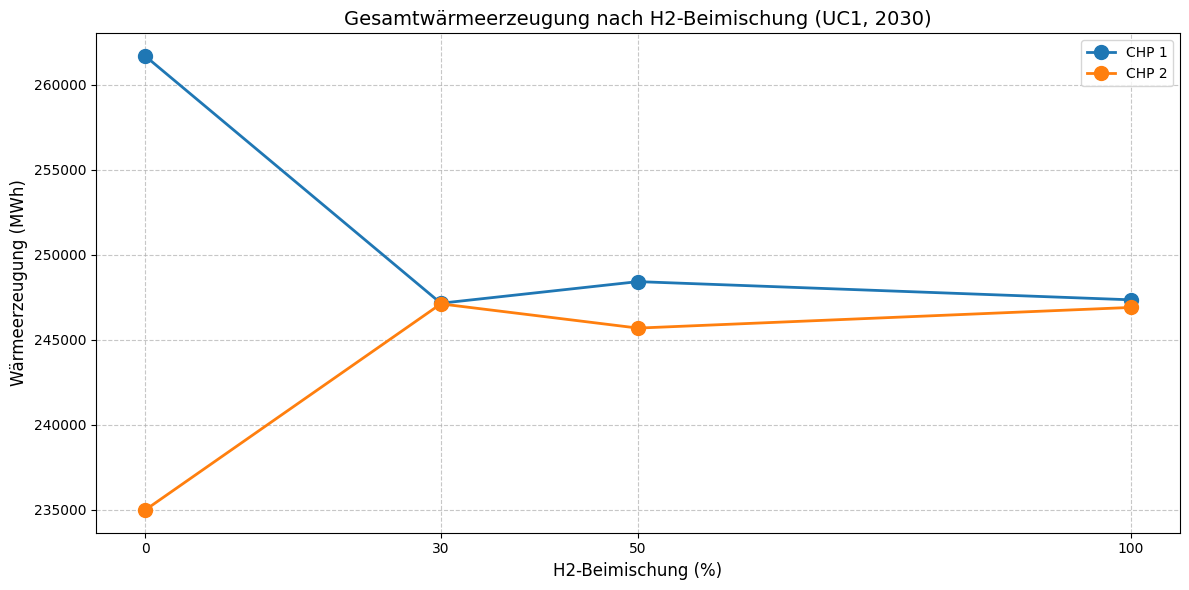

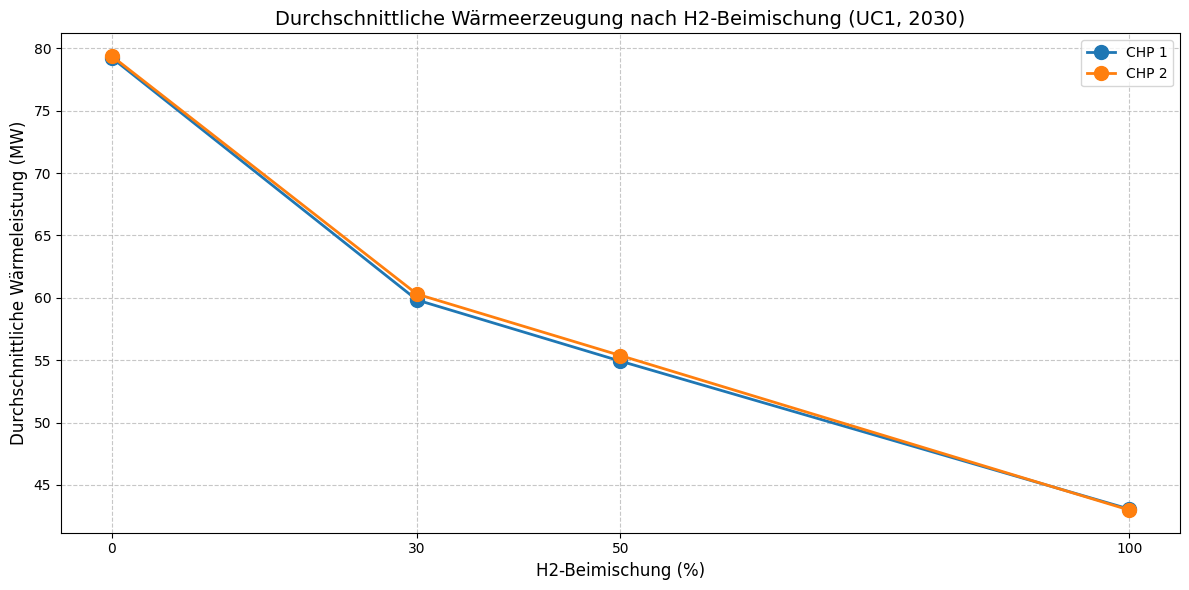

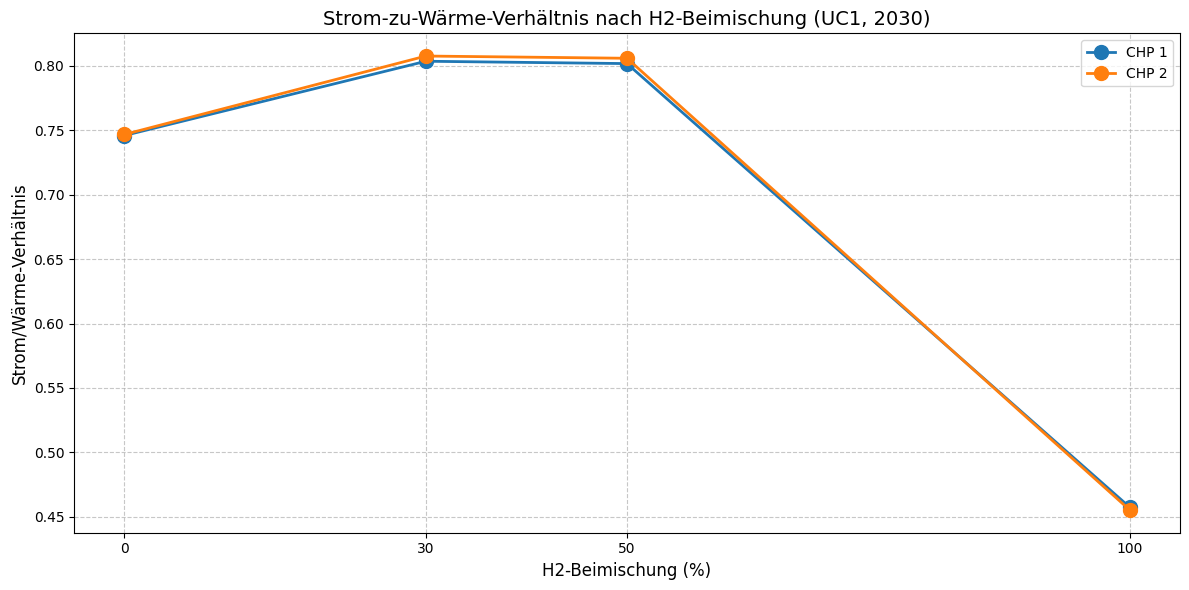

UnboundLocalError: cannot access local variable 'x' where it is not associated with a value

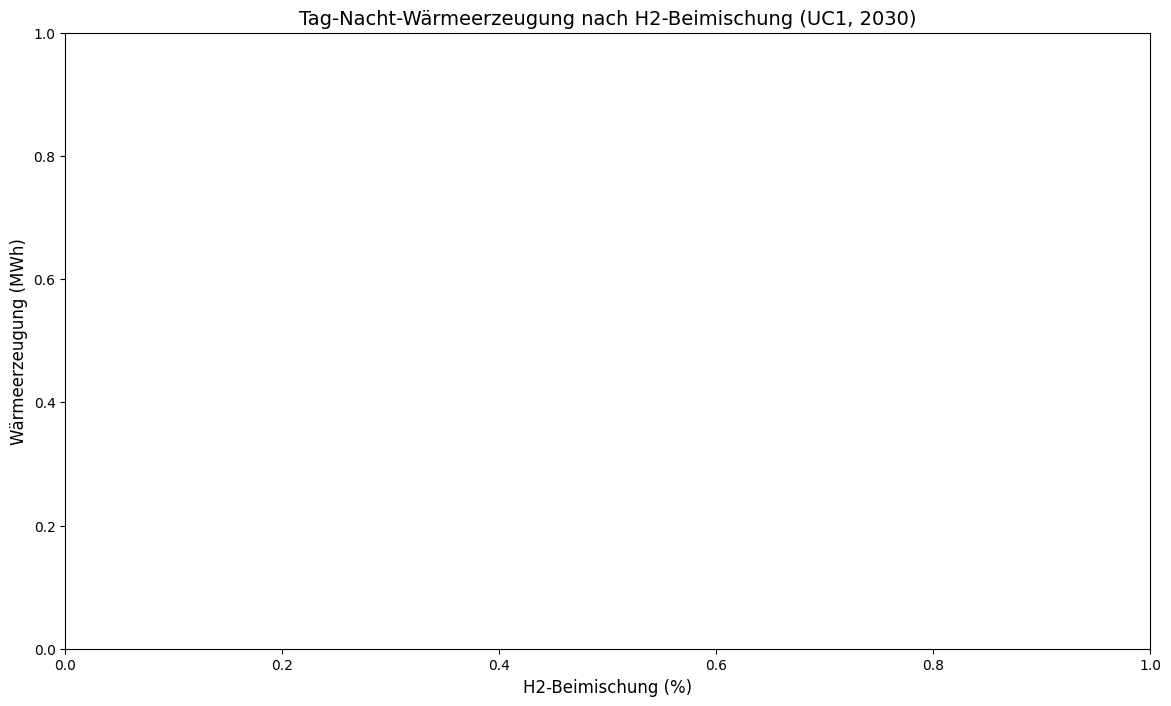

In [ ]:
# Wärmeerzeugungsanalyse durchführen
if 'collection' in locals() and collection.scenarios:
    # CHP-Analyse durchführen
    USE_CASE = "uc1"  # Auf uc1 setzen, wie gewünscht
    YEAR = "2030"     # Auf 2030 setzen, wie gewünscht
    
    # Ausgabeverzeichnis aktualisieren
    CHP_ANALYSIS_DIR = os.path.join(OUTPUT_PATH, f'chp_analysis_{USE_CASE}_{YEAR}')
    os.makedirs(CHP_ANALYSIS_DIR, exist_ok=True)
    
    # Szenarien identifizieren und laden
    selected_scenarios = identify_scenarios(YEAR, USE_CASE)
    
    if selected_scenarios:
        # Falls die collection neu initialisiert werden muss
        if not any(name.startswith(f"{USE_CASE}_{YEAR}") for name in collection.scenarios.keys()):
            for scenario_path in selected_scenarios:
                scenario_name = os.path.basename(scenario_path)
                print(f"Lade {scenario_name}...")
                scenario = ScenarioData(scenario_name, os.path.join(DATA_PATH, os.path.dirname(scenario_path)))
                scenario.load_all_data()
                collection.scenarios[scenario_name] = scenario
            
            # Daten verarbeiten
            collection.preprocess_all().add_datetime_all()
        
        # Wärmeerzeugungsdaten analysieren
        heat_analysis_results = analyze_chp_heat_production(collection)
        
        if heat_analysis_results:
            # Ergebnisse in DataFrame konvertieren
            heat_results_df = pd.DataFrame(heat_analysis_results)
            
            # Spaltennamen für bessere Übersicht kürzen
            heat_results_df = heat_results_df.drop(columns=['hourly_heat', 'time_series'], errors='ignore')
            
            print("\nZusammenfassung der Wärmeerzeugungsanalyse:")
            print(heat_results_df[['scenario', 'chp_unit', 'h2_admixture', 'total_heat', 'avg_heat', 'operating_hours']])
            
            # Ergebnisse speichern
            heat_results_df.to_csv(os.path.join(CHP_ANALYSIS_DIR, f'heat_analysis_{USE_CASE}_{YEAR}.csv'), index=False)
            print(f"Detaillierte Wärmeerzeugungsdaten gespeichert in: {os.path.join(CHP_ANALYSIS_DIR, f'heat_analysis_{USE_CASE}_{YEAR}.csv')}")
            
            # Textuelle Zusammenfassung erstellen
            summarize_heat_findings(heat_results_df)
            
            # Visualisierungen erstellen
            visualize_chp_heat_production(heat_results_df)
        else:
            print("Keine Wärmeerzeugungsdaten für die Analyse gefunden.")
    else:
        print(f"Keine Szenarien für {USE_CASE}_{YEAR} mit H2-Beimischungen {H2_ADMIXTURES} gefunden.")
else:
    print("Keine Szenarien für die Wärmeerzeugungsanalyse verfügbar.")

In [ ]:
# Prüfe die Verzeichnisstruktur
print("\nVerfügbare Hauptverzeichnisse im Datenpfad:")
if os.path.exists(DATA_PATH):
    top_dirs = [d for d in os.listdir(DATA_PATH) if os.path.isdir(os.path.join(DATA_PATH, d))]
    for d in top_dirs:
        print(f"- {d}")
else:
    print(f"WARNUNG: Der Pfad {DATA_PATH} existiert nicht!")

# Prüfe, ob uc1 und uc2 Verzeichnisse existieren
uc1_dir = os.path.join(DATA_PATH, 'uc1')
uc2_dir = os.path.join(DATA_PATH, 'uc2')

uc1_exists = os.path.exists(uc1_dir)
uc2_exists = os.path.exists(uc2_dir)

# Finde die Szenarien in den Unterverzeichnissen
uc1_scenarios = []
uc2_scenarios = []

if uc1_exists:
    print("\nGefundene UC1-Verzeichnisse:")
    uc1_scenario_dirs = [d for d in os.listdir(uc1_dir) if os.path.isdir(os.path.join(uc1_dir, d))]
    for d in uc1_scenario_dirs:
        # Prüfe, ob output-Dateien vorhanden sind
        has_output = len(glob.glob(os.path.join(uc1_dir, d, '*_output.csv'))) > 0
        print(f"- {d} {'(mit Output-Dateien)' if has_output else '(keine Output-Dateien)'}")
        if has_output:
            uc1_scenarios.append(os.path.join('uc1', d))  # Pfad relativ zu DATA_PATH

if uc2_exists:
    print("\nGefundene UC2-Verzeichnisse:")
    uc2_scenario_dirs = [d for d in os.listdir(uc2_dir) if os.path.isdir(os.path.join(uc2_dir, d))]
    for d in uc2_scenario_dirs:
        # Prüfe, ob output-Dateien vorhanden sind
        has_output = len(glob.glob(os.path.join(uc2_dir, d, '*_output.csv'))) > 0
        print(f"- {d} {'(mit Output-Dateien)' if has_output else '(keine Output-Dateien)'}")
        if has_output:
            uc2_scenarios.append(os.path.join('uc2', d))  # Pfad relativ zu DATA_PATH

# Zusammenfassung
print(f"\nUC1 Szenarien mit Output-Dateien: {len(uc1_scenarios)}")
print(f"UC2 Szenarien mit Output-Dateien: {len(uc2_scenarios)}")


Verfügbare Hauptverzeichnisse im Datenpfad:
- archive
- dummy
- postprocessing
- uc1
- uc2

Gefundene UC1-Verzeichnisse:
- uc1_2028_0h2 (mit Output-Dateien)
- uc1_2028_100h2 (mit Output-Dateien)
- uc1_2028_30h2 (mit Output-Dateien)
- uc1_2028_50h2 (mit Output-Dateien)
- uc1_2030_0h2 (mit Output-Dateien)
- uc1_2030_100h2 (mit Output-Dateien)
- uc1_2030_30h2 (mit Output-Dateien)
- uc1_2030_50h2 (mit Output-Dateien)
- uc1_2040_0h2 (mit Output-Dateien)
- uc1_2040_100h2 (mit Output-Dateien)
- uc1_2040_30h2 (mit Output-Dateien)
- uc1_2040_50h2 (mit Output-Dateien)
- uc1_2050_0h2 (mit Output-Dateien)
- uc1_2050_100h2 (mit Output-Dateien)
- uc1_2050_30h2 (mit Output-Dateien)
- uc1_2050_50h2 (mit Output-Dateien)

Gefundene UC2-Verzeichnisse:
- uc2_2030_0h2_2xco2 (mit Output-Dateien)
- uc2_2030_100h2_2xco2 (mit Output-Dateien)
- uc2_2030_30h2_2xco2 (mit Output-Dateien)
- uc2_2030_50h2_2xco2 (mit Output-Dateien)
- uc2_2040_0h2_2xco2 (mit Output-Dateien)
- uc2_2040_100h2_2xco2 (mit Output-Dateien

In [ ]:
# Szenariosammlung initialisieren
collection = ScenarioCollection(DATA_PATH)

# Alle verfügbaren Szenarien laden
all_scenarios = uc1_scenarios + uc2_scenarios
if all_scenarios:
    print(f"\nLade {len(all_scenarios)} Szenarien...")
    
    # Lade nur maximal 4 Szenarien (je 2 von UC1 und UC2) für schnellere Tests
    # Entferne diese Einschränkung, wenn du alle Szenarien laden möchtest
    uc1_sample = uc1_scenarios if len(uc1_scenarios) > 0 else []
    uc2_sample = uc2_scenarios if len(uc2_scenarios) > 0 else []
    sample_scenarios = uc1_sample + uc2_sample
    
    for scenario_path in sample_scenarios:
        scenario_name = os.path.basename(scenario_path)
        print(f"Lade {scenario_name}...")
        scenario = ScenarioData(scenario_name, os.path.join(DATA_PATH, os.path.dirname(scenario_path)))
        scenario.load_all_data()
        collection.scenarios[scenario_name] = scenario
    
    # Daten verarbeiten
    collection.preprocess_all().add_datetime_all()
    
    # Szenarioübersicht anzeigen
    print("\n--- Verfügbare Szenarien ---")
    for name, scenario in collection.scenarios.items():
        summary = scenario.summary()
        h2_level = summary.get("scenario_info", {}).get("hydrogen_admixture_chp1", "N/A")
        print(f"Szenario: {name}, H2-Beimischung: {h2_level}")
else:
    print("\nKeine UC1/UC2 Szenarien mit Output-Dateien gefunden. Die Analyse kann nicht fortgesetzt werden.")


Lade 28 Szenarien...
Lade uc1_2028_0h2...
Kostendaten aus uc1_2028_0h2_20250430_135332_costs.json geladen.
Metadaten aus uc1_2028_0h2_20250430_135332_metadata.json geladen.
Ausgabedaten aus uc1_2028_0h2_20250430_135332_output.csv geladen.
Lade uc1_2028_100h2...
Kostendaten aus uc1_2028_100h2_20250430_140145_costs.json geladen.
Metadaten aus uc1_2028_100h2_20250430_140145_metadata.json geladen.
Ausgabedaten aus uc1_2028_100h2_20250430_140145_output.csv geladen.
Lade uc1_2028_30h2...
Kostendaten aus uc1_2028_30h2_20250430_140729_costs.json geladen.
Metadaten aus uc1_2028_30h2_20250430_140729_metadata.json geladen.
Ausgabedaten aus uc1_2028_30h2_20250430_140729_output.csv geladen.
Lade uc1_2028_50h2...
Kostendaten aus uc1_2028_50h2_20250430_141234_costs.json geladen.
Metadaten aus uc1_2028_50h2_20250430_141234_metadata.json geladen.
Ausgabedaten aus uc1_2028_50h2_20250430_141234_output.csv geladen.
Lade uc1_2030_0h2...
Kostendaten aus uc1_2030_0h2_20250430_141740_costs.json geladen.
Meta

## 2. Daten laden

Laden Sie die Simulationsdaten für die verschiedenen Szenarien.

## 3. Datenverarbeitung

Verarbeiten Sie die geladenen Daten für die Analyse.

# Energiesystem-Simulation Postprocessing: Szenariovergleich

Dieses Notebook dient der Auswertung und dem Vergleich von Simulationsergebnissen verschiedener Szenarien.
Es verwendet die `Scenario`-Klasse aus `postprocessing.utils.scenario_data` für den Datenzugriff.

**Ziele:**
- Laden von spezifischen Szenariodaten (Zeitreihen, Kosten, Metadaten).
- Berechnung von Kennzahlen (z.B. Critical Spark Spread).
- Visualisierung der Ergebnisse.
- Ermöglichung flexibler Vergleiche zwischen Szenarien.

In [1]:
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import os
import sys

# Add the utils directory to the Python path to import the Scenario class
# This assumes the notebook is in postprocessing/notebooks/ and scenario_data.py is in postprocessing/utils/
module_path = os.path.abspath(os.path.join("..", "utils"))
if (module_path not in sys.path):
    sys.path.append(module_path)

try:
    from scenario_data import Scenario
except ImportError as e:
    print(f"Error importing Scenario class: {e}")
    print("Please ensure 'scenario_data.py' is in the 'postprocessing/utils' directory and the path is correct.")

pd.options.plotting.backend = "plotly"

## 1. Konfiguration und Szenariodefinition

Definieren Sie den Basispfad zu den Simulationsergebnissen und initialisieren Sie die Szenarien, die analysiert werden sollen.
Der `base_data_path` sollte relativ zum Speicherort dieses Notebooks sein.

In [2]:
# Define the base path to the simulation output data directory
# This notebook is in postprocessing/notebooks/, so data/output/ is ../../data/output/
BASE_DATA_PATH = os.path.abspath(os.path.join("..", "..", "data", "output"))

print(f"Basispfad für Daten: {BASE_DATA_PATH}")
if not os.path.exists(BASE_DATA_PATH):
    print(f"WARNUNG: Der Basispfad {BASE_DATA_PATH} existiert nicht. Bitte überprüfen Sie den Pfad.")

# Define scenarios for analysis
# Use Case 1: Standard CO2 price
# Scenario 1: uc1, 2030, 0% H2
try:
    scenario_uc1_0h2 = Scenario(
        base_data_path=BASE_DATA_PATH,
        use_case="uc1",
        year=2030,
        h2_pct=0,
        co2_multiplier=False 
    )
    print(f"Szenario 1 geladen: {scenario_uc1_0h2}")

    # Scenario 2: uc1, 2030, 100% H2
    scenario_uc1_100h2 = Scenario(
        base_data_path=BASE_DATA_PATH,
        use_case="uc1",
        year=2030,
        h2_pct=100,
        co2_multiplier=False
    )
    print(f"Szenario 2 geladen: {scenario_uc1_100h2}")

except FileNotFoundError as e:
    print(f"Fehler beim Initialisieren eines Szenarios: {e}")
    print("Stellen Sie sicher, dass die Datenverzeichnisse und Dateien für die angegebenen Szenarien existieren.")
except ValueError as e:
    print(f"Fehler bei den Szenarioparametern: {e}")
except Exception as e:
    print(f"Ein unerwarteter Fehler ist aufgetreten: {e}")


Basispfad für Daten: c:\Users\wlhlm\VSCodeProjects\burn4h2\data\output
Szenario 1 geladen: <Scenario: uc1_2030_0h2 ( use_case='uc1', year=2030, h2_pct=0, co2_multiplier=False)>
Szenario 2 geladen: <Scenario: uc1_2030_100h2 ( use_case='uc1', year=2030, h2_pct=100, co2_multiplier=False)>


In [3]:
# Load data for the scenarios
try:
    data_uc1_0h2_output = scenario_uc1_0h2.load_output_data()
    costs_uc1_0h2 = scenario_uc1_0h2.load_costs_data()
    metadata_uc1_0h2 = scenario_uc1_0h2.load_metadata()
    chp_asset_data_uc1_0h2 = scenario_uc1_0h2.load_chp_asset_data() # New line
    print(f"Daten für {scenario_uc1_0h2.scenario_name_identifier} geladen.")
    print("Output Daten (erste 5 Zeilen):")
    print(data_uc1_0h2_output.head())
    if chp_asset_data_uc1_0h2 is not None: # New block
        print("\nCHP Asset Daten (uc1_0h2):")
        print(chp_asset_data_uc1_0h2)

    data_uc1_100h2_output = scenario_uc1_100h2.load_output_data()
    costs_uc1_100h2 = scenario_uc1_100h2.load_costs_data()
    metadata_uc1_100h2 = scenario_uc1_100h2.load_metadata()
    chp_asset_data_uc1_100h2 = scenario_uc1_100h2.load_chp_asset_data() # New line
    print(f"\nDaten für {scenario_uc1_100h2.scenario_name_identifier} geladen.")
    print("Output Daten (erste 5 Zeilen):")
    print(data_uc1_100h2_output.head())
    if chp_asset_data_uc1_100h2 is not None: # New block
        print("\nCHP Asset Daten (uc1_100h2):")
        print(chp_asset_data_uc1_100h2)

except NameError:
    print("Fehler: Szenario-Objekte wurden aufgrund eines vorherigen Fehlers nicht erstellt.")
except FileNotFoundError as e:
    print(f"Fehler beim Laden der Daten: {e}")
except Exception as e:
    print(f"Ein unerwarteter Fehler beim Laden der Daten ist aufgetreten: {e}")


Daten für uc1_2030_0h2 geladen.
Output Daten (erste 5 Zeilen):
   t  gas_price  power_price  hydrogen_price  heat_demand  local_heat_demand  \
0  1     23.693        75.01      186.656315      96.5540           1.322578   
1  2     23.693        85.88      186.656315      97.6990           1.374841   
2  3     23.693        74.00      186.656315      95.3175           1.369030   
3  4     23.693        74.00      186.656315      95.7440           1.420452   
4  5     23.693        74.00      186.656315      94.0390           1.465191   

   supply_temperature  return_temperature  solar_thermal_heat_profile  \
0                80.0                55.0                         0.0   
1                80.0                55.0                         0.0   
2                80.0                55.0                         0.0   
3                80.0                55.0                         0.0   
4                80.0                55.0                         0.0   

   normalized_sol

In [26]:
data_uc1_0h2_output['power_price']

0       75.01
1       85.88
2       74.00
3       74.00
4       74.00
        ...  
8755    94.91
8756    94.91
8757    91.99
8758    91.90
8759    86.11
Name: power_price, Length: 8760, dtype: float64

## 3. Berechnung des Critical Spark Spread

Der Critical Spark Spread (CSS) wird berechnet als:

In [33]:
def calculate_critical_spark_spread(output_data, costs_data, metadata, scenario_h2_pct, chp_asset_data):
    """
    Berechnet den Critical Spark Spread als Zeitreihe.
    Args:
        output_data (pd.DataFrame): DataFrame mit Zeitreihendaten.
        costs_data (dict): Dictionary mit Kostendaten.
        metadata (dict): Dictionary mit Metadaten.
        scenario_h2_pct (int): H2-Anteil des Szenarios.
        chp_asset_data (pd.DataFrame, optional): DataFrame mit CHP-Asset-Kenndaten.
                                                  Erwartet 'max' als Index und 'power', 'gas' als Spalten.
    """
    
    # --- ANPASSUNGEN ERFORDERLICH ---
    electricity_price_col = 'power_price'
    gas_price_col = 'gas_price'           
    h2_price_col = 'hydrogen_price' 
    
    # Preis
    co2_price = metadata['CO2_PRICE']
    power_price = output_data[electricity_price_col]
    gas_price = output_data[gas_price_col]
    h2_price = output_data[h2_price_col]
    
    # Admixture-Parameter
    h2_admixture = metadata['hydrogen_admixture']['chp_1'] * 100  # H2-Beimischung für CHP 1 in % = CHP 2 

    # Volumenverhältnisse (0-1 Skala)
    vol_h2 = h2_admixture / 100  # z.B. 0.3 für 30% H2
    vol_ng = 1 - vol_h2
    
    # Energiedichten [MJ/m³]
    HV_H2 = 120.0  # Hydrogen heating value [MJ/kg]
    HV_NG = 47.0   # Natural gas heating value [MJ/kg]
    RHO_H2 = 0.09  # Hydrogen density [kg/m³]
    RHO_NG = 0.68  # Natural gas density [kg/m³]
    
    energy_density_h2 = RHO_H2 * HV_H2  # ~10.8 MJ/m³
    energy_density_ng = RHO_NG * HV_NG  # ~32.0 MJ/m³
    
    # Energiefraktionen berechnen (aus chp.py-Methoden)
    energy_fraction_h2 = (vol_h2 * energy_density_h2) / (vol_h2 * energy_density_h2 + vol_ng * energy_density_ng)
    energy_fraction_ng = (vol_ng * energy_density_ng) / (vol_h2 * energy_density_h2 + vol_ng * energy_density_ng)


    # Chp Asset Daten
    max_power = chp_asset_data.loc['max', 'power'] 
    min_power = chp_asset_data.loc['min', 'power']

    max_gas = chp_asset_data.loc['max', 'gas']
    min_gas = chp_asset_data.loc['min', 'gas']

    max_co2 = chp_asset_data.loc['max', 'co2']
    min_co2 = chp_asset_data.loc['min', 'co2']

    results_df = pd.DataFrame()
    results_df['power_price'] = power_price
    results_df['gas_price'] = gas_price
    results_df['hydrogen_price'] = h2_price
    results_df['co2_price'] = co2_price

    # Brennstoffkosten für maximale Leistung
    results_df['max_ngas_costs'] = max_gas * energy_fraction_ng * gas_price
    results_df['max_h2_costs'] = max_gas * energy_fraction_h2 * h2_price
    results_df['max_fuel_costs'] = results_df['max_ngas_costs'] + results_df['max_h2_costs']

    # Brennstoffkosten für minimale Leistung
    results_df['min_ngas_costs'] = min_gas * energy_fraction_ng * gas_price
    results_df['min_h2_costs'] = min_gas * energy_fraction_h2 * h2_price
    results_df['min_fuel_costs'] = results_df['min_ngas_costs'] + results_df['min_h2_costs']

    # CO2-Kosten für maximale Leistung
    min_co2_emissions = min_co2 * (1 - h2_admixture/100)
    max_co2_emissions = max_co2 * (1 - h2_admixture/100)
    
    min_co2_costs = min_co2_emissions * co2_price
    max_co2_costs = max_co2_emissions * co2_price

    results_df['max_total_costs'] = results_df['max_fuel_costs'] + max_co2_costs
    results_df['min_total_costs'] = results_df['min_fuel_costs'] + min_co2_costs


    # Zusätzliche Kosten

    results_df['additional_costs'] = results_df['max_total_costs'] - results_df['min_total_costs']
    results_df['additional_power'] = max_power - min_power

    # Critical Spark Spread berechnen (€/MWh)
    results_df['critical_spark_spread'] = results_df['additional_costs'] / results_df['additional_power']



    print(results_df.head())

    return results_df  


In [ ]:
df =calculate_critical_spark_spread(
    output_data=data_uc1_0h2_output,
    costs_data=costs_uc1_0h2,
    metadata=metadata_uc1_0h2,
    scenario_h2_pct=0,
    chp_asset_data=chp_asset_data_uc1_0h2
)



   power_price  gas_price  hydrogen_price  co2_price  max_ngas_costs  \
0        75.01     23.693      186.656315      125.0     3703.879304   
1        85.88     23.693      186.656315      125.0     3703.879304   
2        74.00     23.693      186.656315      125.0     3703.879304   
3        74.00     23.693      186.656315      125.0     3703.879304   
4        74.00     23.693      186.656315      125.0     3703.879304   

   max_h2_costs  max_fuel_costs  min_ngas_costs  min_h2_costs  min_fuel_costs  \
0           0.0     3703.879304     1535.164242           0.0     1535.164242   
1           0.0     3703.879304     1535.164242           0.0     1535.164242   
2           0.0     3703.879304     1535.164242           0.0     1535.164242   
3           0.0     3703.879304     1535.164242           0.0     1535.164242   
4           0.0     3703.879304     1535.164242           0.0     1535.164242   

   max_total_costs  min_total_costs  additional_costs  additional_power  \
0    

0       91.215572
1       91.215572
2       91.215572
3       91.215572
4       91.215572
          ...    
8755    91.215572
8756    91.215572
8757    91.215572
8758    91.215572
8759    91.215572
Name: critical_spark_spread, Length: 8760, dtype: float64

## 4. Visualisierung des Critical Spark Spread

## 5. Weitere Analysen und Vergleiche

Dieser Bereich steht für Ihre benutzerdefinierten Analysen zur Verfügung.

In [ ]:
print("Fügen Sie hier Ihre eigenen Codezellen für weitere Analysen hinzu.")
# Beispiel: 
# scenario_uc2_2040_100h2 = Scenario(base_data_path=BASE_DATA_PATH, use_case="uc2", year=2040, h2_pct=100, co2_multiplier=True)
# data_uc2_2040_100h2_output = scenario_uc2_2040_100h2.load_output_data()
# costs_uc2_2040_100h2 = scenario_uc2_2040_100h2.load_costs_data()
# print(costs_uc2_2040_100h2)